<a href="https://colab.research.google.com/github/khushishelat/GenderBiasSportsJournalism/blob/Khushi/TennisData_TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from copy import deepcopy
from string import punctuation
from random import randint
import numpy as np
from PIL import Image
from git import Repo
from pathlib import Path
from nltk.stem.snowball import SnowballStemmer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cities_df = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/names_locations/world-cities.csv')
names_df = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/names_locations/players.csv')
states_df = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/names_locations/states.csv')
state_names_df = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/names_locations/StateNames.csv')
nat_names_df = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/names_locations/NationalNames.csv')

In [5]:
questions_df = pd.read_json('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/questions_matchinfo.json', orient='index')
commentaries_df = pd.read_json('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/text_commentaries.json')
transcripts_df = pd.read_json('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/transcripts_matchinfo.json', orient='index')

# Helper Functions / Background Computations

In [6]:
from git import Repo
from pathlib import Path

In [7]:
# get word valence, arousal, and dominance scores dataframe
def get_xanew(root=Path.home()/'data',
              subfolder='X-ANEW',
              url='https://github.com/JULIELab/X-ANEW.git'):

    target_folder = root / subfolder

    if not target_folder.is_dir():
        target_folder.mkdir(parents=True, exist_ok=True)
        print('Downloading the dataset from github...')
        Repo.clone_from(url, str(target_folder))

    csv = target_folder / 'Ratings_Warriner_et_al.csv'
    df = pd.read_csv(csv, index_col=0)
    df = df[['Word', 'V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
    df.columns = ['word', 'valence', 'arousal', 'dominance']
    df.set_index('word', inplace=True)

    return df

# downloads the dataset if necessary and returns a pandas DataFrame
vad_word_df = get_xanew()
vad_word_df


valence  arousal  dominance
word                                    
aardvark        6.26     2.41       4.27
abalone         5.30     2.65       4.95
abandon         2.84     3.73       3.32
abandonment     2.63     4.95       2.64
abbey           5.85     2.20       5.00
...              ...      ...        ...
zone            4.75     3.78       5.23
zoning          4.65     3.77       4.47
zoo             7.00     5.63       6.33
zoom            5.86     5.68       5.90
zucchini        6.30     4.18       6.19

[13915 rows x 3 columns]

In [8]:
cities_df['cities'] = cities_df['name'].apply(lambda x: x.lower())
cities_df['country'] = cities_df['country'].apply(lambda x: x.lower())
cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).lower())

states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).lower())
states_df['states'] = states_df['States'].apply(lambda x: str(x).lower())

state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).lower())
nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).lower())

names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).lower())
names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).lower())


for p in punctuation:
  cities_df['cities'] = cities_df['cities'].apply(lambda x: str(x).replace(p, ''))
  cities_df['country'] = cities_df['country'].apply(lambda x: str(x).replace(p, ''))
  cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).replace(p, ''))
  states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).replace(p, ''))
  states_df['states'] = states_df['States'].apply(lambda x: str(x).replace(p, ''))
  state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).replace(p, ''))
  names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).replace(p, ''))


cities = list(set(cities_df['cities'].to_list()))
countries = list(set(cities_df['country'].to_list()))
subcountries = list(set(cities_df['subcountry'].to_list()))
us_cities = list(set(states_df['cities'].to_list()))
us_states = list(set(states_df['states'].to_list()))
state_names = list(set(state_names_df['Name'].to_list()))
nat_names = list(set(nat_names_df['Name'].to_list()))
first_names = list(set(names_df['first_name'].to_list()))
last_names = list(set(names_df['last_name'].to_list()))


names = []
names.extend(first_names)
names.extend(last_names)
names = list(set(names))
names.extend(state_names)
names = list(set(names))
names.extend(nat_names)
names = list(set(names))

locations = []
locations.extend(cities)
locations.extend(us_cities)
locations = list(set(locations))
locations.extend(us_states)
locations.extend(countries)
locations.extend(subcountries)
locations = list(set(locations))

In [9]:
contractions = ["we're", "you're", "they're", "there's", "haven't", "doesn't",
                "must've", "could've", "should've", "might've", "wouldn't",
                "couldn't", "would've", "can't", "won't", "isn't", "wasn't",
                "he's", "she's", "he'll", "she'll", "he'd", "she'd", "they've",
                "they'll", "they'd"]

symbols = "',.()!?\"\\/"

questions_words = ' '.join(questions_df.explode(column='questions')['questions']).split()
commentary_words = ' '.join(commentaries_df.explode(column='commentary')['commentary']).split()

my_ques_df = pd.DataFrame(questions_words, columns =['words'])
my_comm_df = pd.DataFrame(commentary_words, columns =['words'])

# make lowercase
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.lower())
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.lower())

# remove ending punctuation
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)

# remove punctuation
for p in punctuation:
  my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)
  my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)

# remove duplicates
questions_words = list(set(my_ques_df['words'].to_list()))
commentary_words = list(set(my_comm_df['words'].to_list()))

answers = []
for interview in transcripts_df['QandA'].to_list():
  for qna in interview:
    answers.append(qna[1])

split_words = [words.split() for words in answers]
answers_words = []
for words in split_words:
  for word in words:
    word = word.lower()
    if word[-1] in symbols:
      word = word[0:-1]
    if word not in contractions:
      for p in punctuation:
        word = word.replace(p, '')
    answers_words.append(word)

all_words = []
all_words.extend(list(set(questions_words)))
all_words.extend(list(set(commentary_words)))
all_words.extend(list(set(answers_words)))
all_words = list(set(all_words))

In [10]:
# Get list of names and gender specific words to remove during EDA

# Explode Questions column
questions_df_cleaned = questions_df.explode(column='questions')
commentaries_df_cleaned = commentaries_df.explode(column='commentary')
transcripts_df_cleaned = transcripts_df.explode(column='QandA')


# gender specific words, country-related words, and previous players
manual_remove_words = ['he', 'him', 'his', 'she', 'her', 'hers', "he's", "she's",
                       "he'll", "she'll", "he'd", "she'd", 'man', 'men', 'mens',
                       'woman', 'women', 'womens', 'guy', 'girl', 'guys',
                       'girls', 'male', 'female', 'himself', 'herself',
                       'serenas', 'boris', 'agassi', 'sampras', 'del', 'potro',
                       'atp', 'wta', 'fed', 'agut', 'frenchman', 'swiss',
                       'serb', 'serbian', 'russian', 'french', 'american',
                       'australian', 'canadian', 'spanish', 'spaniard', 'scot',
                       'belarusian', 'brit', 'italian', 'german', 'english',
                       'murrays', 'one', 'two', 'three', 'four', 'five', 'six',
                       'seven', 'eight', 'nine', 'ten', 'japan', 'japanese',
                       'china', 'chinese', 'first', 'second', 'third', 'fourth',
                       'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth',
                       'london', 'shanghai', 'montecarlo', 'wuhan', 'queens',
                       'melbourne', 'singapore', 'eastbourne', 'york', 'polish',
                       'israel', 'florida', 'pole', 'onetwo', 'andre', 'pete',
                       'dubai', 'istanbul', 'australia', 'vika', 'mcenroe',
                       'barcelona', 'sydney', 'madrid', 'brad', 'jo', 'doha',
                       'england', 'lendl', 'nigel', 'borg', 'gonzlez', 'steffi',
                       'america', 'bernie', 'billie', 'charleston', 'switzerland',
                       'stuttgart', 'aga', 'bestofthree', 'jimmy', 'connors',
                       'jean', 'spain', 'south', 'africa', 'russia', 'germany',
                       'flipkens', 'birmingham', 'twosetter', 'twoset',
                       'threesetter', 'threeset', 'foursetter', 'fourset',
                       'fivesetter', 'fiveset', 'graf', 'laver', 'navratilova',
                       'tony', 'moscow', 'stefan', 'italy', 'ashe', 'evert',
                       'genie', 'romania', 'goran', 'washington', 'cincinnati',
                       'belgium', 'bercy', 'sugarpova', 'montreal', 'toronto',
                       'halle', 'stanford', 'seles', 'hobart', 'san', 'diego',
                       'los', 'angeles', 'york', 'poland', 'achale', 'kooyong',
                       'sunday', 'monday', 'tuesday', 'wednesday', 'thursday',
                       'friday', 'saturday', 'georgia', 'argentina', 'hanburg',
                       'sven', 'california', 'casse', 'etienne', 'federernadal',
                       'gracialopez', 'caas', 'magnus', 'pattaya', 'courier',
                       'turkish', 'loydra', 'sasha', 'petko', 'chernobyl',
                       'rafa', 'llodra', 'knowles', 'fifthset', 'williamses',
                       'golubev', 'shell', 'hogstedt', 'allaster', 'annacone',
                       'dhabi', 'piatti', 'allwilliams', 'ncaas', 'ncaa',
                       'shoaxuan', 'swedes', 'supersaturday', 'ponte',
                       'belgians', 'belgian', 'stanislas', 'puerto', 'twohour',
                       'roig', 'matsuoka', 'garcialopez', 'ukrainian',
                       'frenchwoman', 'djoko', 'greek', 'belorussian', 'muzza',
                       'makarvoa', 'zealander', 'berydch', 'wellexecuted',
                       'highquality', 'delpo', 'lpez', 'portuguese', 'rola',
                       'croat', 'dutchman', 'dutchwoman', 'chinatown',
                       'allrussian', 'duval', 'ghangzou', 'romanians',
                       'brazilian', 'swedish', "they've", "they're", "they's",
                       "they'll", "they'd", "there's", "you", "your", "you're",
                       "there"]


"""player names from the data (questions and interviews dataframes)"""

# make lowercase
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: x.lower())
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: x.lower())
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: x.lower())

# remove ending punctuation
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))

# remove punctation
for p in punctuation:
    questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)

# remove duplicates
q_players = list(set(questions_df_cleaned['player'].to_list()))
a_players = list(set(transcripts_df['player'].to_list()))
a_opp_players = list(set(transcripts_df['opponent'].to_list()))

# get first/last names
q_first_names = [player.split()[0] if len(player.split()) > 1 else player.split()[0] for player in q_players]
q_last_names = [player.split()[1] for player in q_players]
a_first_names = [player.split()[0] for player in a_players]
a_last_names = [player.split()[1] for player in a_players]
a_opp_first_names = [player.split()[0] for player in a_opp_players]
a_opp_last_names = [player.split()[1] if len(player.split()) > 1 else player.split()[0] for player in a_opp_players]

# remove duplicates
q_first_names = list(set(q_first_names))
q_last_names = list(set(q_last_names))
a_first_names = list(set(a_first_names))
a_last_names = list(set(a_last_names))
a_opp_first_names = list(set(a_opp_first_names))
a_opp_last_names = list(set(a_opp_last_names))

# combine names and gender specific words into one list of words to be removed
remove_words = manual_remove_words + q_first_names + q_last_names + a_first_names + a_last_names + a_opp_first_names + a_opp_last_names + names + locations
remove_words = list(set(remove_words))

# get intersection of remove words and all words
removed_words = list(set(all_words) & set(remove_words))
removed_words_df = pd.DataFrame(removed_words, columns =['words'])

# save the removed words to a dataframe for later use
removed_words_df.to_csv('removed_words.zip', index=False,
          compression=dict(method='zip', archive_name='removed_words.csv')  )

In [11]:
# function to get words occurring disproportionately with males and females
def get_diff_words(male_words, female_words, remove_words, n_stds,
                   graph_name=None):

  Counter(male_words)

  # lowercase words and remove punctuation
  male_words_cleaned = []
  female_words_cleaned = []

  for pair in Counter(male_words).most_common():
    m_word = pair[0].lower()
    m_count = pair[1]
    if m_word[-1] in symbols:
      m_word = m_word[0:-1]
    if m_word in contractions:
      if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])
    else:
      if not set(m_word).intersection('0123456789'):
        for p in punctuation:
          m_word = m_word.replace(p, '')
        if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])

  for pair in Counter(female_words).most_common():
    f_word = pair[0].lower()
    f_count = pair[1]
    if f_word[-1] in symbols:
      f_word = f_word[0:-1]
    if f_word in contractions:
      if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])
    else:
      if not set(f_word).intersection('0123456789'):
        for p in punctuation:
          f_word = f_word.replace(p, '')
        if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])

  # rename cleaned list
  male_words = male_words_cleaned
  female_words = female_words_cleaned

  # get list of male and female word count tuples
  male_word_counts = list(dict(Counter(male_words)).values())
  female_word_counts = list(dict(Counter(female_words)).values())

  # get respective desired cutoffs for number of standard deviations above mean
  male_freq_cutoff = n_stds*np.std(male_word_counts) + np.mean(male_word_counts)
  female_freq_cutoff = n_stds*np.std(female_word_counts) + np.mean(female_word_counts)

  if graph_name:
    # print means and standard deviations
    print('-------------------------------------------------------------------')
    print("Male Frequency Mean:", np.mean(male_word_counts))
    print("Female Frequency Mean:", np.mean(female_word_counts))
    print("Male Frequency STD:", np.std(male_word_counts))
    print("Female Frequency STD:", np.std(female_word_counts))
    print('-------------------------------------------------------------------')

  """Remove words that appear in both the mens and womens question data and
  appear a certain number of standard deviations above the mean frequency in
  the combined data set."""

  # get male, female, and an intersection Counters
  male_counter = Counter(male_words)
  female_counter = Counter(female_words)

  # get male/female (word, count) tuple lists and list of intersection words
  male_word_count_list = male_counter.most_common()
  female_word_count_list = female_counter.most_common()

  # get list of intersection words that appear more often than the
  #    designated cutoff
  male_top_inter_list = [i[0] for i in male_word_count_list
                        if i[1] > male_freq_cutoff]

  female_top_inter_list = [i[0] for i in female_word_count_list
                          if i[1] > female_freq_cutoff]

  # take the intersection of the male/female intersection lists
  top_inter_list = list(set(male_top_inter_list) & set(female_top_inter_list))

  # create reduced male and female words lists by removing these high frequency
  #    intersection words
  male_words_red = [[pair[0] for _ in range(pair[1])] for pair in male_word_count_list if pair[0] not in top_inter_list]
  female_words_red = [[pair[0] for _ in range(pair[1])] for pair in female_word_count_list if pair[0] not in top_inter_list]
  male_words_red = [word for sublst in male_words_red for word in sublst]
  female_words_red = [word for sublst in female_words_red for word in sublst]

  # get difference in male and female word lengths
  length_diff = len(male_words_red) - len(female_words_red)

  # randomly remove words from bigger list until both are the same size
  if length_diff > 0:
    for _ in range(length_diff):
      male_words_red.pop(randint(0, len(male_words_red)-1))
  else:
    for _ in range(-length_diff):
      female_words_red.pop(randint(0, len(female_words_red)-1))

  # get counts of reduced lists
  male_counter_red = Counter(male_words_red)
  female_counter_red = Counter(female_words_red)

  if graph_name:
    # print sizes of each list to make sure they match
    print('Male Word Count:', male_counter_red.total())
    print('Female Word Count:', female_counter_red.total())
    print('-------------------------------------------------------------------')

  """Time to get the differences when subtracting each of the counts from
  the other."""

  # copy male and female counters
  male_diff_counter = deepcopy(male_counter_red)
  female_diff_counter = deepcopy(female_counter_red)

  # subtract each from the other to get the difference in counts
  male_diff_counter.subtract(female_counter_red)
  female_diff_counter.subtract(male_counter_red)

  # get male and female elements from these words more associated with each
  male_elements = sorted(male_diff_counter.elements())
  female_elements = sorted(female_diff_counter.elements())

  # get male and female diff lists of tuple (word, counts)
  male_diff_list = male_diff_counter.most_common()
  female_diff_list = female_diff_counter.most_common()

  if graph_name:

    """Create word clouds for the male/female results"""

    # male world cloud
    male_mask = np.array(Image.open("/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Images/male_symbol.jpg"))
    male_wordcloud = WordCloud(width=10, height=15, mask=male_mask,
                          background_color='navy').fit_words(dict(male_diff_list))

    # female world cloud
    female_mask = np.array(Image.open("/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Images/female_symbol.jpg"))
    female_wordcloud = WordCloud(width=10, height=15, mask=female_mask,
                          background_color='pink').fit_words(dict(female_diff_list))

    # Display the generated word cloud using matplotlib
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
    ax1.imshow(male_wordcloud.recolor(color_func=male_color_func, random_state=3), interpolation='bilinear')
    ax2.imshow(female_wordcloud.recolor(color_func=female_color_func, random_state=3), interpolation='bilinear')
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title("Disproportionately Male-Occurring Words", fontsize = 12)
    ax2.set_title("Disproportionately Female-Occurring Words", fontsize = 12)
    if n_stds:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 22)
    else:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above the mean)", fontsize = 22)

  return (male_elements, female_elements), (male_counter_red, female_counter_red), (male_diff_list, female_diff_list)

In [12]:
      # elif stemmer.stem("generalized") in vad_word_df:
      #   word = stemmer.stem("generalized")
      #   valence.append(vad_word_df.loc[word]['valence'])
      #   arousal.append(vad_word_df.loc[word]['arousal'])
      #   dominance.append(vad_word_df.loc[word]['dominance'])
      #   words_included.append(word)
      # else:

In [13]:
def get_avg_vad(male_words, female_words, remove_words, n_stds, graph_name=None):

  elements = get_diff_words(male_words, female_words, remove_words, n_stds)[0]
  stemmer = SnowballStemmer("english")

  output_lst = []
  print('-------------------------------------------------------------------')
  for i, lst in enumerate(elements):
    valence = []
    arousal = []
    dominance = []
    words_included = []
    words_excluded = []
    for word in lst:
      if word in vad_word_df.index:
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 1 and word[-1] == 's' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 1 and word[-1] == 'y' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 2 and word[-2:] == 'ed' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 2 and word[-2:] == 'er' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 2 and word[-2:] == 'ly' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ing' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ity' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ery' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ant' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ism' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 4 and word[-4:] == 'ness' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 4 and word[-4:] == 'ment' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 4 and word[-4:] == 'ship' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif stemmer.stem(word) in vad_word_df:
        word = stemmer.stem(word)
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      else:
        words_excluded.append(word)
    output_lst.append((valence, arousal, dominance))

    if i:
      name = "Female"
    else:
      name = "Male"
    print(name + " Percentage of Words Included:", round(len(words_included) /
                                                    (len(words_included) +
                                                    len(words_excluded)), 2))
    print('-------------------------------------------------------------------')

    if not graph_name:
      print(name + " Average Valence:", round(np.mean(valence), 2))
      print(name + " Average Arousal:", round(np.mean(arousal), 2))
      print(name + " Average Dominance:", round(np.mean(dominance), 2))


  if graph_name:

    combined_v = output_lst[0][0] + output_lst[1][0]
    combined_a = output_lst[0][1] + output_lst[1][1]
    combined_d = output_lst[0][2] + output_lst[1][2]
    combined_vad_scores = combined_v + combined_a + combined_d
    combined_vad_labels = ['valence' for _ in range(len(combined_v))] + ['arousal' for _ in range(len(combined_a))] + ['dominance' for _ in range(len(combined_d))]
    combined_g = 3*(['M' for _ in range(len(output_lst[0][0]))] + ['F' for _ in range(len(output_lst[1][0]))])

    df = pd.DataFrame(list(zip(combined_vad_labels, combined_vad_scores, combined_g)),
                columns=['label', 'score', 'gender'])

    # create custom colors array
    colors = ["#001ba1", "#fc90ab"]
    # set custom color palette
    sns.set_palette(sns.color_palette(colors))

    ax = sns.barplot(data=df, x='label', y='score',
                    hue='gender', dodge=True, hue_order=['M', 'F'],
                    estimator="mean", errorbar=None)

    ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=10);
    ax.bar_label(ax.containers[1], fmt='%.2f', fontsize=10);

    # Adding labels and title
    plt.xlabel('Word Characteristics', fontsize=12)
    plt.ylabel('Mean Characteristic Score', fontsize=12)
    if n_stds:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 15)
    else:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above the mean)", fontsize = 15)

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

  return output_lst

In [14]:
# Make male/female color functions
def female_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(230, 100%%, %d%%)" % randint(20, 50)

def male_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(5, 55%%, %d%%)" % randint(70, 100)

# Exploring dataframes

Files
-----

* *questions_matchinfo.json* - a JSON file containing the press conference question snippets together with player ranking and game result.
* *transcripts_matchinfo.json* - a JSON file containing full transcripts with more complete match information.
* *text_commentaries.json* - a JSON file containing commentary data.

In [15]:
questions_df.head()

player gender  result  \
0     Andy Murray      M       1   
1  Kevin Anderson      M       0   
2  Kevin Anderson      M       1   
3    Gilles Simon      M       1   
4    Milos Raonic      M       0   

                                           questions  ranking  
0  [That last set seemed like a faultless perform...      3.0  
1  [What was it like out there, Kevin?, That was ...     17.0  
2  [You were saying courtside you haven't done an...     17.0  
3  [Big serving has been sort of the theme for th...     13.0  
4  [How disappointing is that loss for you?, When...      8.0

In [16]:
commentaries_df.head()

commentary  \
0  Makarova slumps back into making unforced erro...   
1  Just look in her match with Heather Watson las...   
2  Sharapova saves a break point to hold her serv...   
3  Erakovic is looking superb behind her serve, a...   
4  She can't save another one and Williams is now...   

                    scoreline gender  
0     Sharapova 6-3* Makarova      F  
1  Williams 3-6 2-1* Azarenka      F  
2     Williams *0-2 Sharapova      F  
3        Robson 1-4* Erakovic      F  
4   Williams 2-6 5-1* Lisicki      F

In [17]:
transcripts_df.head()

QandA  ranking tournament_type  \
0  [[That last set seemed like a faultless perfor...      3.0          ATP500   
1  [[What was it like out there, Kevin?, It was t...     17.0          ATP500   
2  [[You were saying courtside you haven't done a...     17.0          ATP500   
3  [[Big serving has been sort of the theme for t...     13.0          ATP500   
4  [[How disappointing is that loss for you?, The...      8.0          ATP500   

  gender           tournament          player  result       date  \
0      M  AEGON CHAMPIONSHIPS     andy murray       1 2015-06-21   
1      M  AEGON CHAMPIONSHIPS  kevin anderson       0 2015-06-21   
2      M  AEGON CHAMPIONSHIPS  kevin anderson       1 2015-06-20   
3      M  AEGON CHAMPIONSHIPS    gilles simon       1 2015-06-19   
4      M  AEGON CHAMPIONSHIPS    milos raonic       0 2015-06-19   

           stage        opponent  
0      The Final  kevin anderson  
1      The Final     andy murray  
2     Semifinals    gilles simon  
3  Quarterfinals    milos raonic  
4  Quarterfinals    gilles simon

## Questions Data

Post-match press conferences in tennis take place shortly after each match. Players enter a press conference room to face a group of reporters from different news agencies and answer questions posed to them.

This file contains a slightly processed version of the transcript data which we use in our study. It covers a total of 6467 post-match press conferences. Duplicate questions from the same interview are removed.

It is in the form of a JSON file with five fields:
- 'gender': player gender
- 'player': name of the player being interviewed
- 'questions': list of question snippets asked in the press conference. Each entry represents one turn from one reporter.
- 'ranking': ranking of the player
- 'result': 1 indicates the player being interviewed is the match winner; 0 otherwise.

For the full transcript and more complete match information, refer to the transcript data described below.


In [18]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     6467 non-null   object 
 1   gender     6467 non-null   object 
 2   result     6467 non-null   int64  
 3   questions  6467 non-null   object 
 4   ranking    6466 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 303.1+ KB


### All Question Data Word Cloud

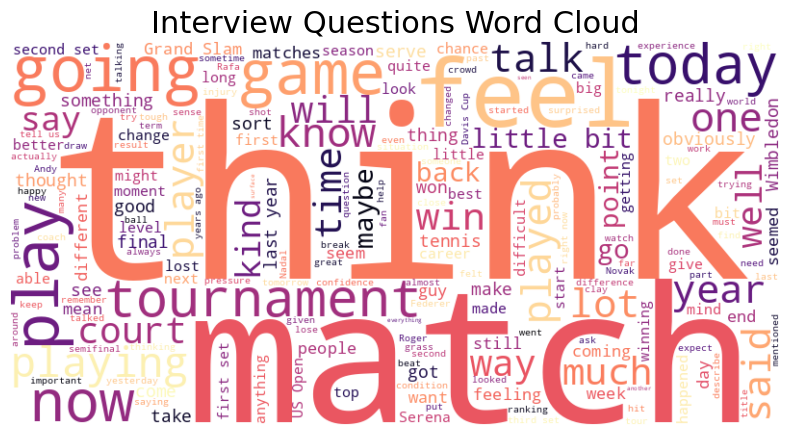

In [19]:
# All Questions Word Cloud
text = ' '.join(questions_df_cleaned['questions'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Interview Questions Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Question Data Word Clouds

In [20]:
# filter into mens and womens data
questions_m_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'M']
questions_f_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'F']
male_text = ' '.join(questions_m_df_cleaned['questions'])
female_text = ' '.join(questions_f_df_cleaned['questions'])

# convert male and female words into lists
male_words = male_text.split()
female_words = female_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 36.10939590408562
Female Frequency Mean: 33.74871443263627
Male Frequency STD: 273.1239232342125
Female Frequency STD: 244.35025151324373
-------------------------------------------------------------------
Male Word Count: 98390
Female Word Count: 98390
-------------------------------------------------------------------


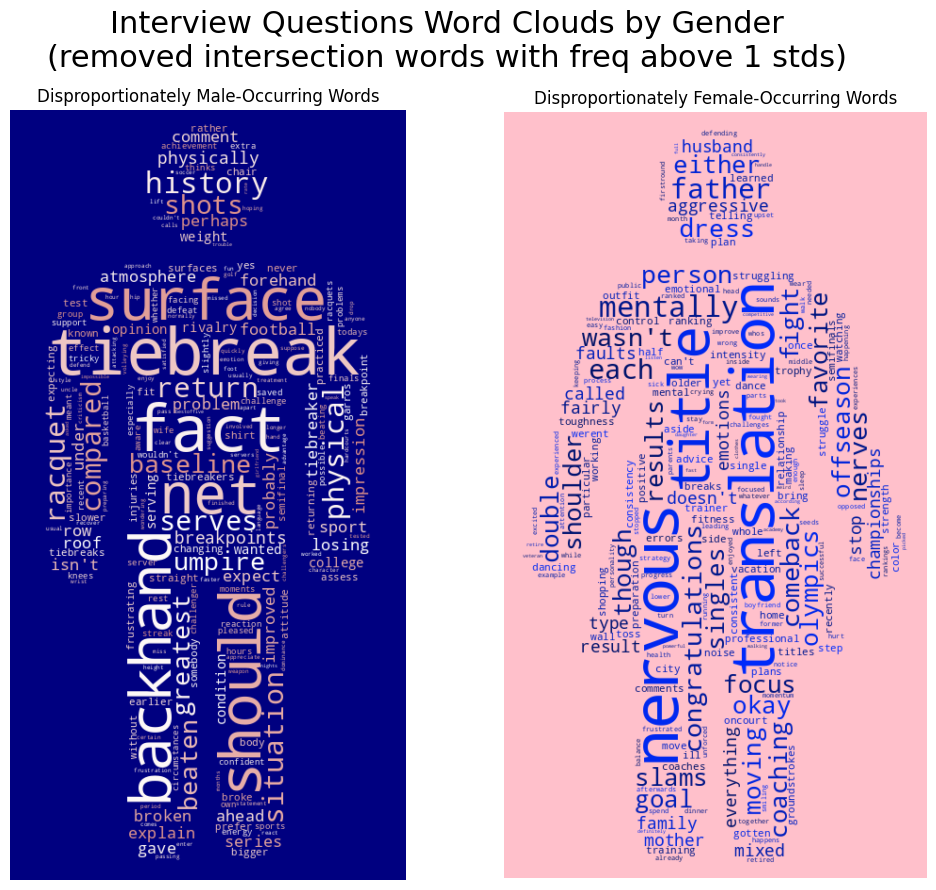

In [21]:
interview_elements, interview_counters, interview_diff_lists = \
get_diff_words(male_words, female_words, remove_words, 1, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.10939590408562
Female Frequency Mean: 33.74871443263627
Male Frequency STD: 273.1239232342125
Female Frequency STD: 244.35025151324373
-------------------------------------------------------------------
Male Word Count: 36251
Female Word Count: 36251
-------------------------------------------------------------------


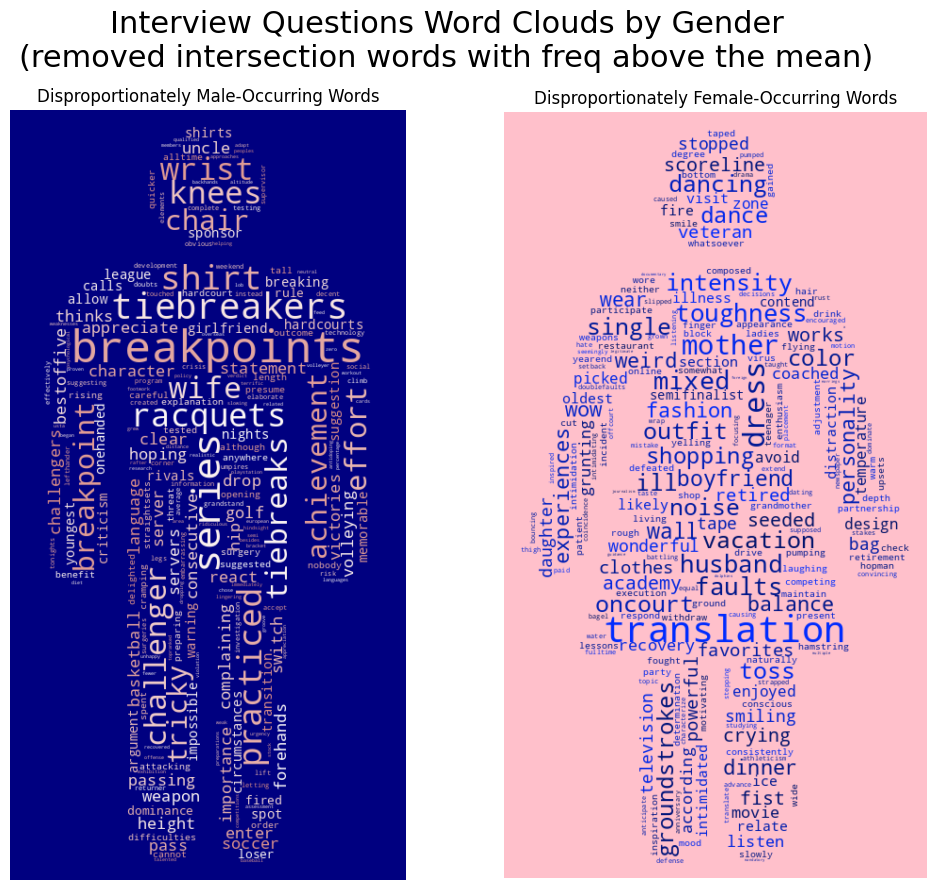

In [22]:
interview_elements, interview_counters, interview_diff_lists = \
get_diff_words(male_words, female_words, remove_words, 0, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.10939590408562
Female Frequency Mean: 33.74871443263627
Male Frequency STD: 273.1239232342125
Female Frequency STD: 244.35025151324373
-------------------------------------------------------------------
Male Word Count: 3900
Female Word Count: 3900
-------------------------------------------------------------------


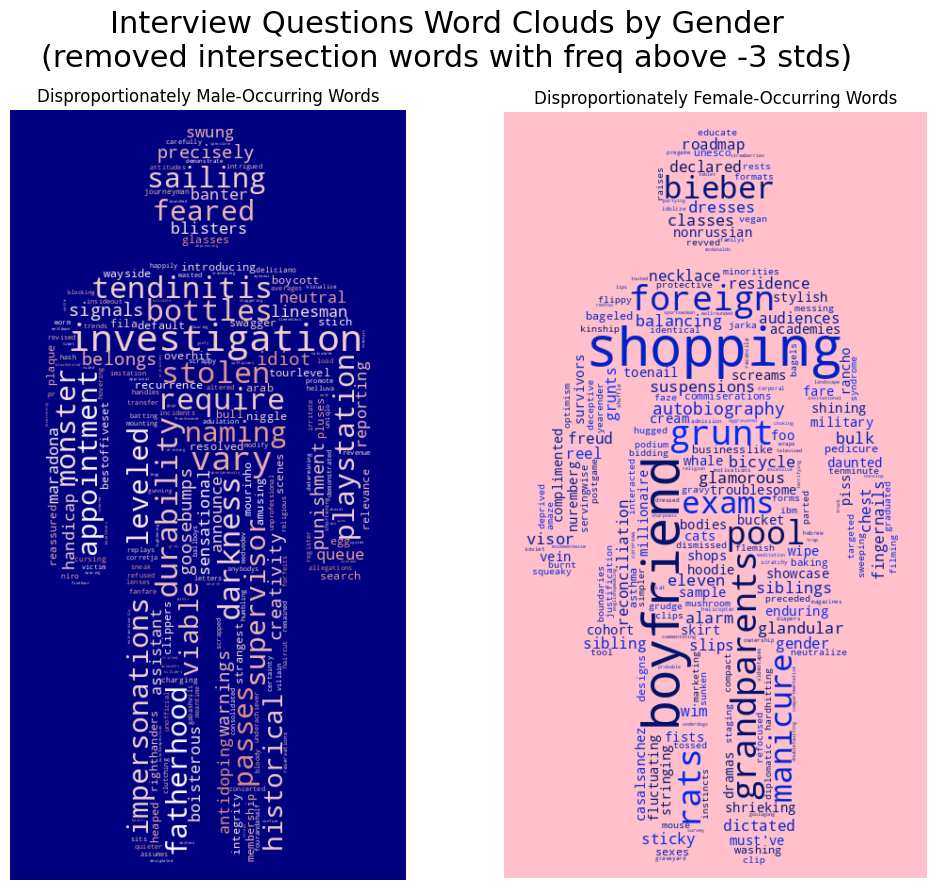

In [23]:
interview_elements, interview_counters, interview_diff_lists = \
get_diff_words(male_words, female_words, remove_words, -3, 'Interview Questions')

### Mean Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.71
-------------------------------------------------------------------


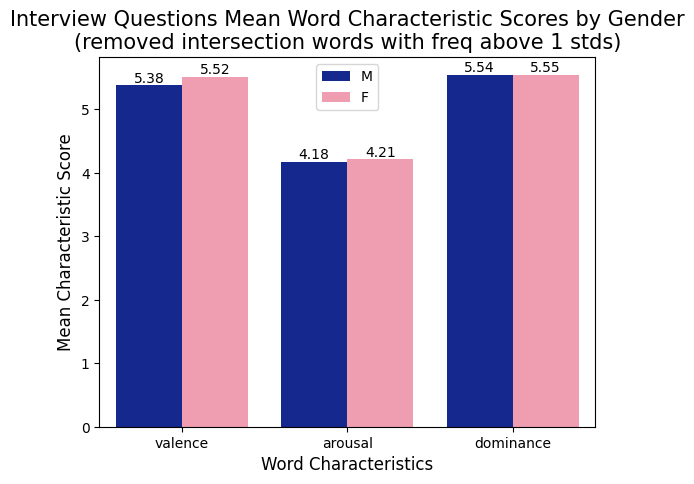

In [24]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's questions, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         1, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.67
-------------------------------------------------------------------
Female Percentage of Words Included: 0.69
-------------------------------------------------------------------


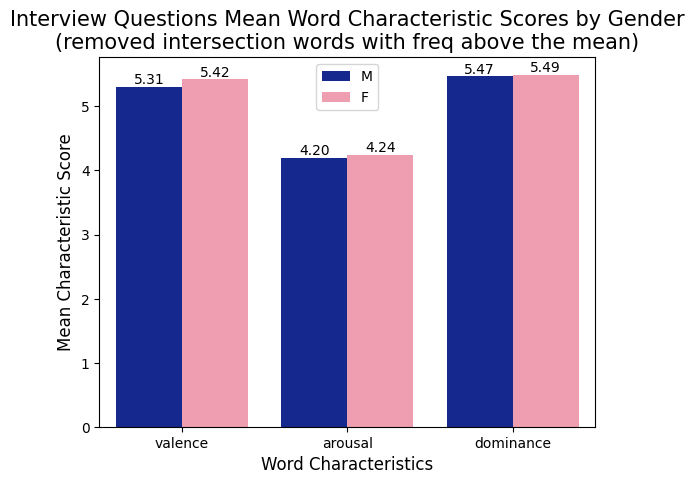

In [25]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         0, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.54
-------------------------------------------------------------------
Female Percentage of Words Included: 0.56
-------------------------------------------------------------------


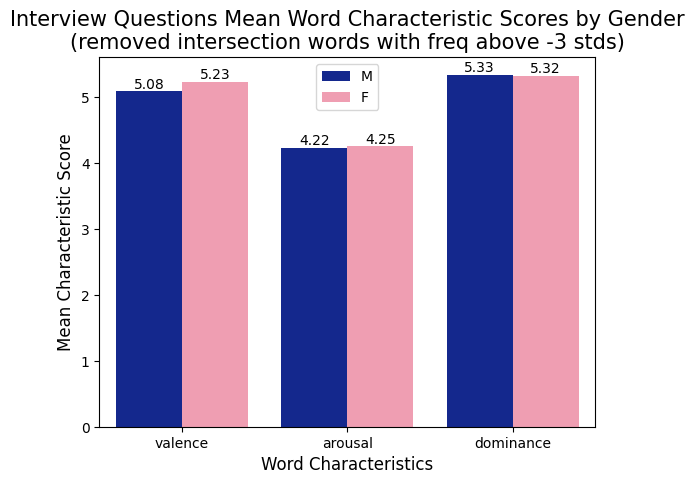

In [26]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         -3, 'Interview Questions')

### Number of Questions Per Ranking For Male and Female Players

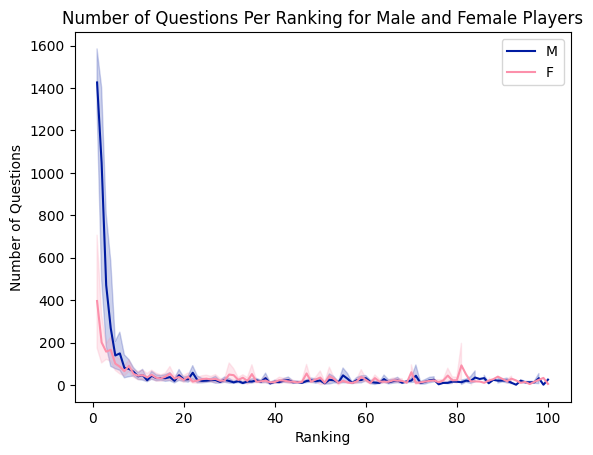

In [27]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_100 = question_counts[question_counts['ranking']<=100]
sns.lineplot(data=top_100, x='ranking', y='questions', hue='gender')

# Adding labels and title
plt.xlabel('Ranking')
plt.ylabel('Number of Questions')
plt.title('Number of Questions Per Ranking for Male and Female Players')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Number of Questions for Male and Female Players in the Top 5

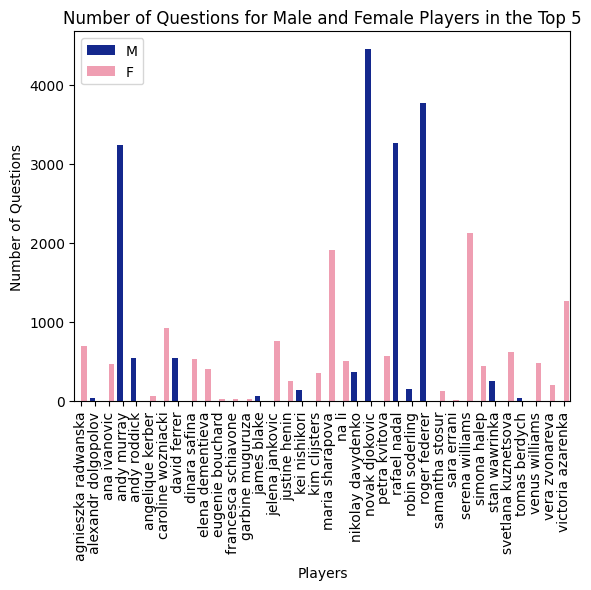

In [28]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_5 = question_counts[question_counts['ranking']<=5]
top_5 = top_5.groupby(['player', 'gender'])[['questions']].sum().reset_index()
sns.barplot(data=top_5, x='player', y='questions', hue='gender', hue_order=['M', 'F'])

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

# Adding labels and title
plt.xlabel('Players')
plt.xticks(rotation=90)
plt.ylabel('Number of Questions')
plt.title('Number of Questions for Male and Female Players in the Top 5')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

## Commentaries Data

The commentary data contains 3962 pieces of live-text play-by-play commentaries, split evenly between men and women singles matches. It is a JSON file with three fields:

	- 'commentary': the actual text from the live updates. It describes the process of the game.
	- 'gender': 'F' indicates the update is from a women's match; 'M' means it is from men's game.
	- 'scoreline': the score when the text update is posted. * indicates the player who is serving at the moment.

While we used Sports Mole's commentaries for our study, ByTheMinute could be another source to gather similar data.



In [29]:
commentaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3962 entries, 0 to 3961
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   commentary  3962 non-null   object
 1   scoreline   3962 non-null   object
 2   gender      3962 non-null   object
dtypes: object(3)
memory usage: 93.0+ KB


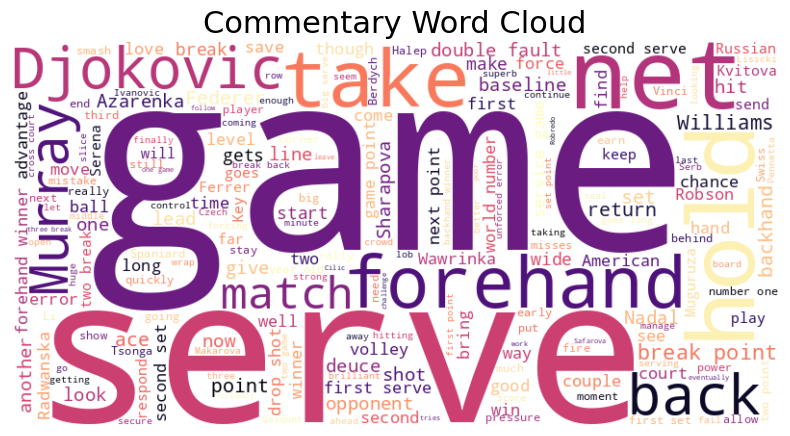

In [30]:
# All Commentary Word Cloud
text = ' '.join(commentaries_df['commentary'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Commentary Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Commentary Data Word Clouds

In [31]:
# Remove gender specific words, player names, case, and punctuation.

# filter into mens and womens data
commentary_m_df = commentaries_df[commentaries_df['gender'] == 'M']
commentary_f_df = commentaries_df[commentaries_df['gender'] == 'F']
male_text = ' '.join(commentary_m_df['commentary'])
female_text = ' '.join(commentary_f_df['commentary'])

# convert male and female words into lists
male_words = male_text.split()
female_words = female_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 12.803529803529804
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 61.06285304645142
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 17306
Female Word Count: 17306
-------------------------------------------------------------------


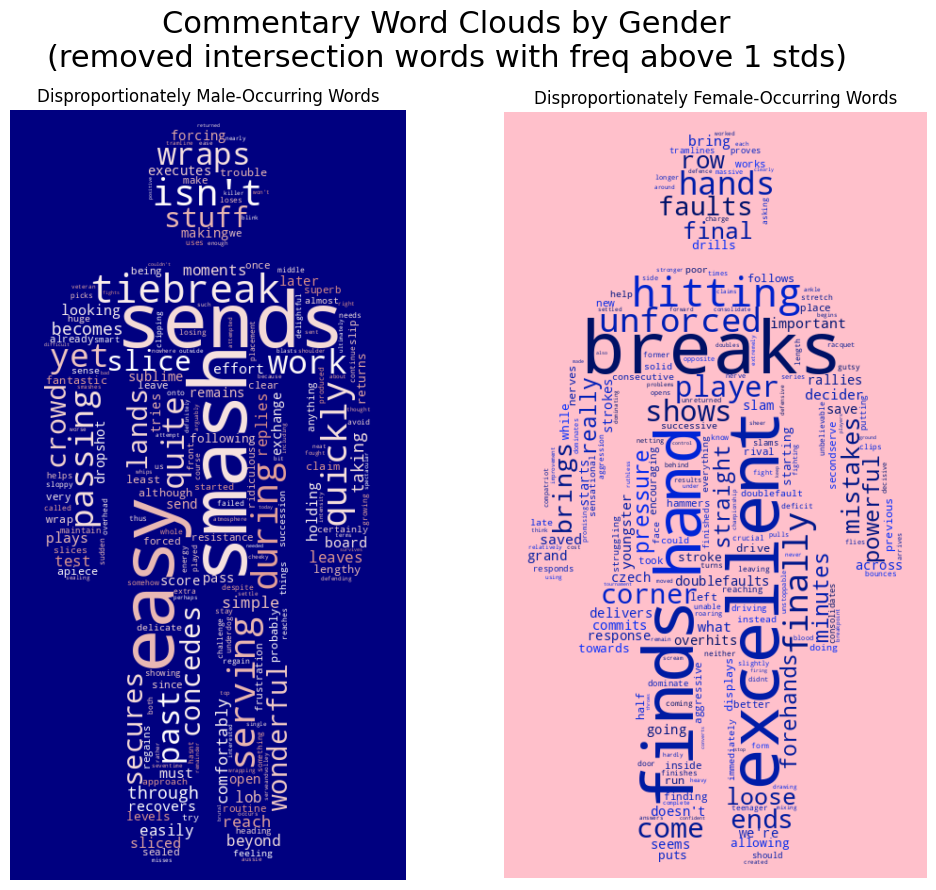

In [32]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 1, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.803529803529804
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 61.06285304645142
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 7665
Female Word Count: 7665
-------------------------------------------------------------------


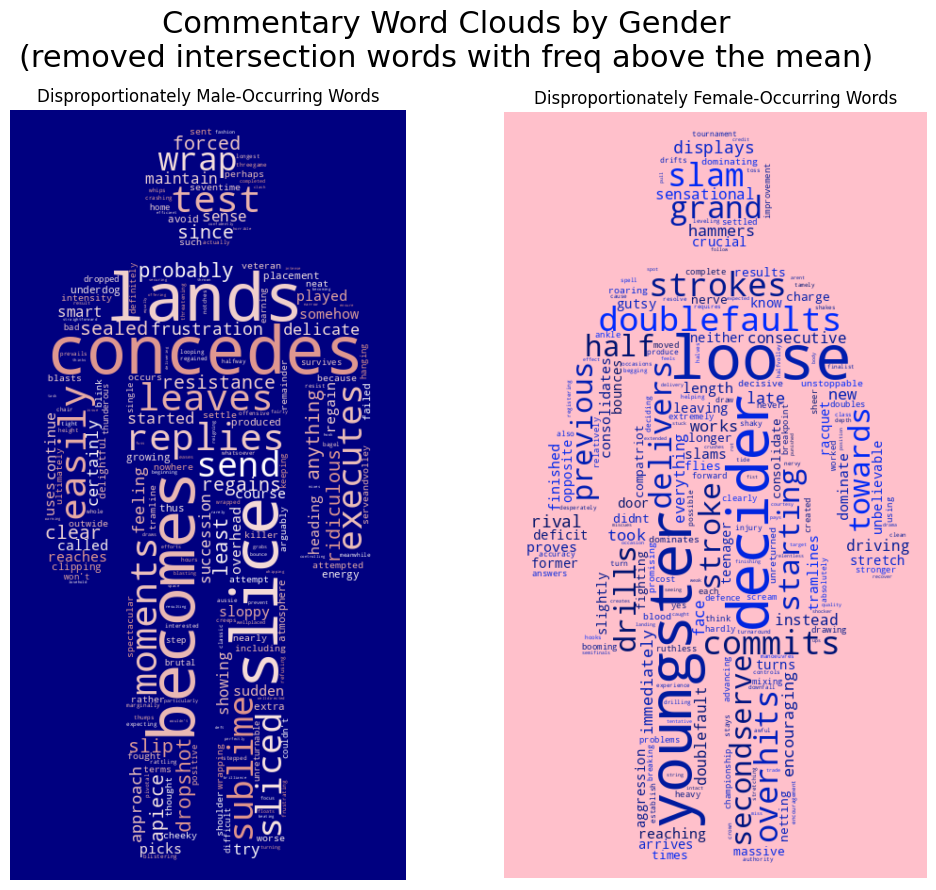

In [33]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 0, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.803529803529804
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 61.06285304645142
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 1257
Female Word Count: 1257
-------------------------------------------------------------------


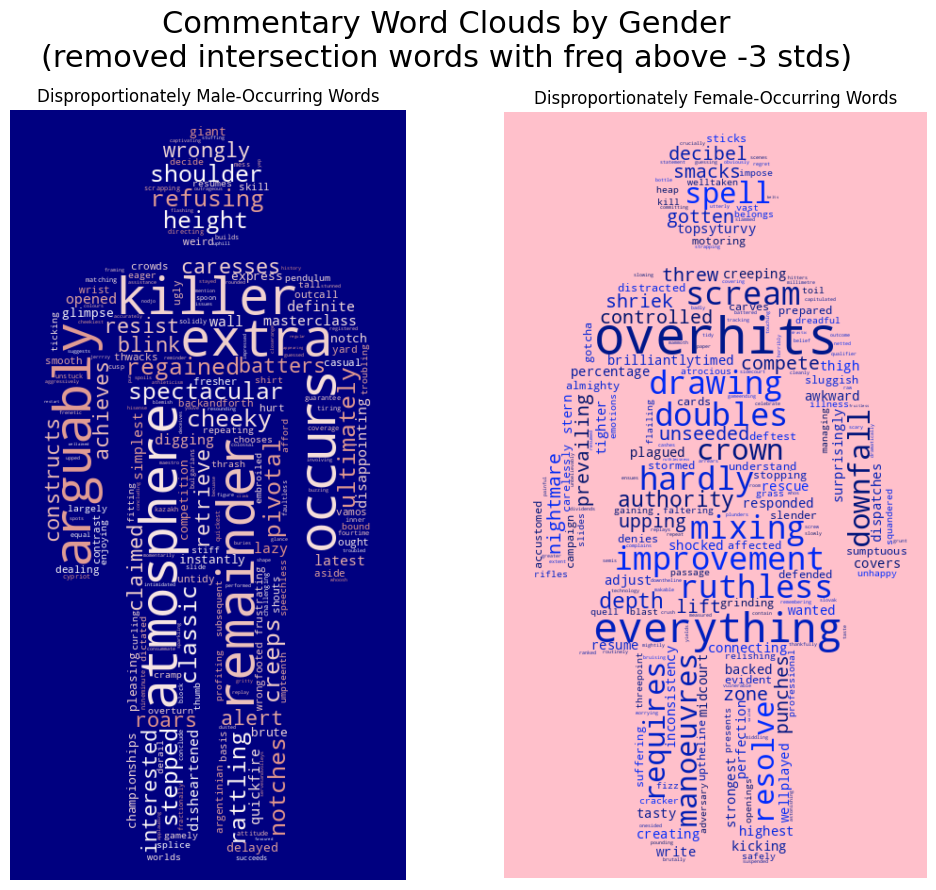

In [34]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, -3, 'Commentary')

### Mean Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.65
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


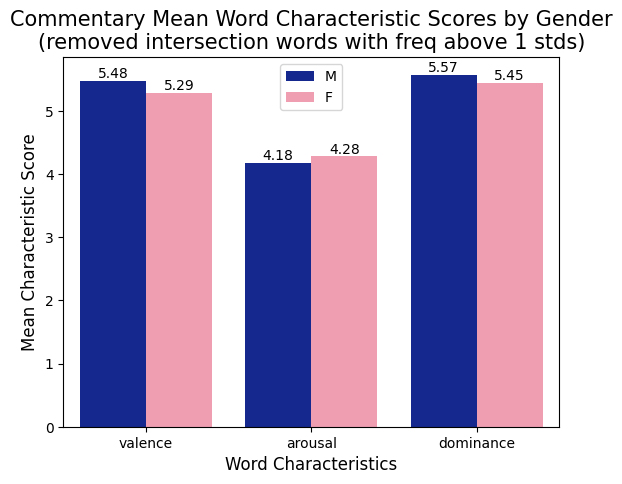

In [35]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's commentary, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         1, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.66
-------------------------------------------------------------------
Female Percentage of Words Included: 0.7
-------------------------------------------------------------------


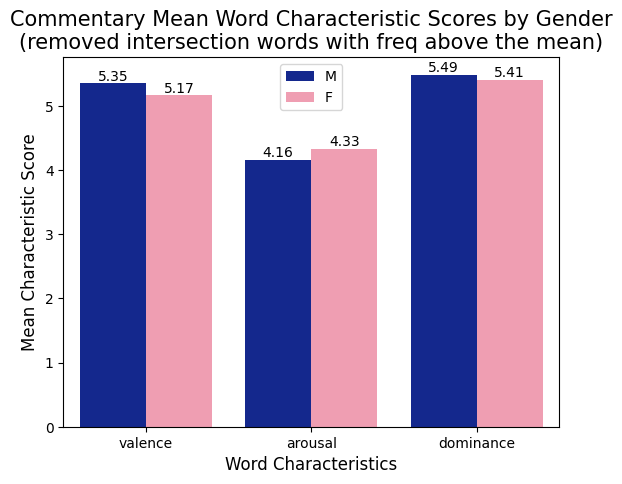

In [36]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         0, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.64
-------------------------------------------------------------------
Female Percentage of Words Included: 0.65
-------------------------------------------------------------------


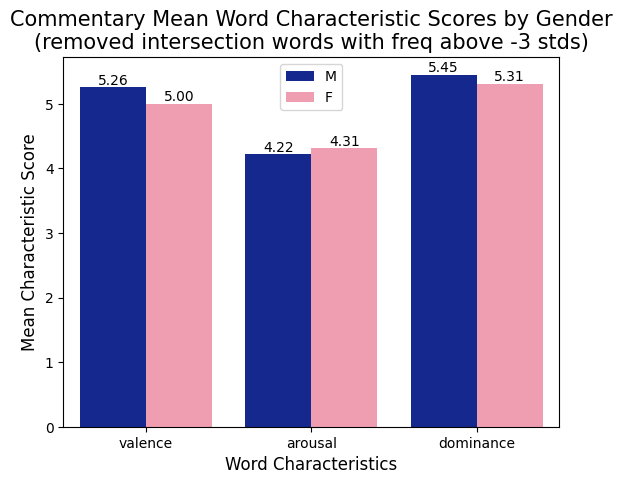

In [37]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         -3, 'Commentary')

### Number of Commentaries for Male and Female Players

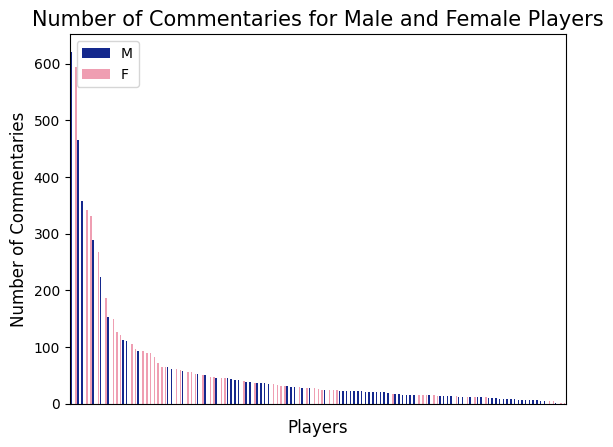

In [38]:
# combine players into a single column to explore how interviews are divided up

# get two players columns
commentaries_df['player1'] = commentaries_df['scoreline'].apply(lambda x: x.split()[0].replace('*', ''))
commentaries_df['player2'] = commentaries_df['scoreline'].apply(lambda x: x.split()[len(x.split())-1].replace('*', ''))

# concat the dataframe with itself with one combined player column
df1 = commentaries_df
df1 = df1.drop(columns='player2')
df1 = df1.rename(columns={'player1':'player'})
df2 = commentaries_df
df2 = df2.drop(columns='player1')
df2 = df2.rename(columns={'player2':'player'})
frames = [df1, df2]
combined_commentaries_df = pd.concat(frames)
player_comm_feq_df = combined_commentaries_df.groupby(by=["player", "gender"])[['commentary']].count().reset_index()
player_comm_feq_df = player_comm_feq_df.sort_values(by='commentary', ascending=False)

# Commentaries per player by gender

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=player_comm_feq_df, x='player', y='commentary',
                 hue='gender', hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Number of Commentaries for Male and Female Players', fontsize = 15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Players with the Most Commentaries

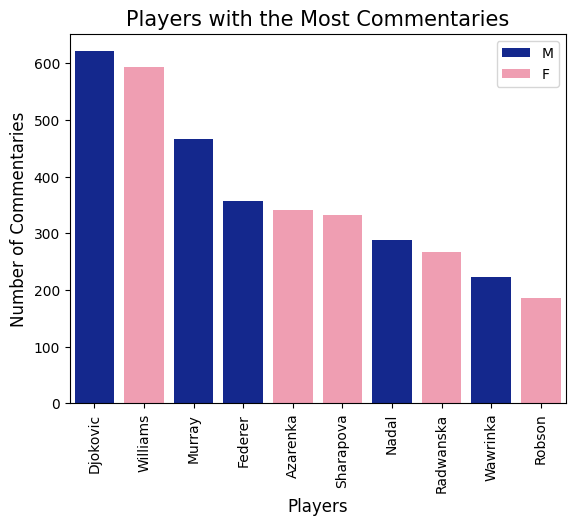

In [39]:
# The players with the most commentaries (10 most)
top_player_comm_freq_df = player_comm_feq_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=top_player_comm_freq_df, x='player', y='commentary', hue='gender',
                 dodge=False, hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Players with the Most Commentaries', fontsize=15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Comentary Word Count Distribution by Gender

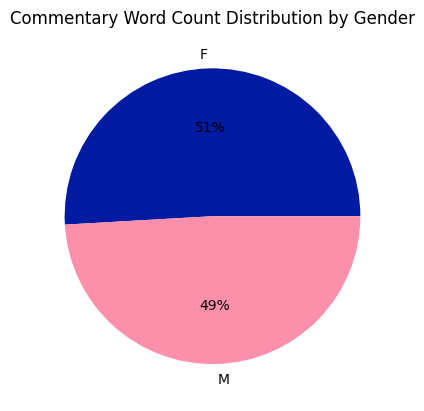

In [40]:
# explore how the number of words are divded up among male/female commentaries
commentaries_df[['commentary', 'gender']]
commentaries_df['word_length'] = commentaries_df['commentary'].apply(lambda x: len(x))
gender_comm_word_counts_df = commentaries_df.groupby(by=['gender'])[['word_length']].sum().reset_index()

# plotting data on chart

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

plt.pie(data=gender_comm_word_counts_df, x= 'word_length', labels='gender',
        autopct='%.0f%%')

plt.title('Commentary Word Count Distribution by Gender')

# displaying chart
plt.show()

## Transcripts Data

The dataset provide the full transcript (i.e. both questions and player responses), in the format of a JSON file:

	>>> import json
	>>> with open("transcripts_matchinfo.json", "r") as f:
	...		interviews = json.load(f)

	The following is an example for one transcript, with each field explained:

	>>> interview = interviews['0']
	0: {
		'QandA': ...  
			# Interview transcripts in the format of a list of question answer pairs.   
		'date': '2015-06-21',  # date the match is played
		'gender': 'M', # 'F' indicates women's singles match, 'M' indicates men's.
		'opponent': 'Kevin Anderson', # opponent in the match
			(available only if the opponent has at least one interview recorded in our dataset.)
  		'player': 'Andy Murray', # player being interviewed
  		'ranking': 3, # ranking of the player
  		'result': 1,  # 1 indicates the player being interviewed has won the match; 0 otherwise.
    		'stage': 'The Final', # stage of the tournament
  		'tournament': 'AEGON CHAMPIONSHIPS' # tournament name
		'tournament_type': 'ATP500', # type of the tournament, indicating tournament prestige.
	}

Note that:

- These questions and answers are transcribed exactly the way the journalists and the players put it; they are not further edited for grammatical correctness. There are, although relatively rarely, questions that are marked as (Off microphone.), (Indiscernible) or even (Translated from X) where X is a language other than English.
- Information about which journalist asked which question is not available.
- This transcript data does not contain all singles press conference transcripts available at ASAP sports as we only included transcripts that we could find corresponding match information for. In addition, since transcripts data and match results are matched by date and player last name, and we did not manually check for every match, it is possible to have a few matching errors.



In [41]:
transcripts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QandA            6467 non-null   object        
 1   ranking          6466 non-null   float64       
 2   tournament_type  6467 non-null   object        
 3   gender           6467 non-null   object        
 4   tournament       6467 non-null   object        
 5   player           6467 non-null   object        
 6   result           6467 non-null   int64         
 7   date             6467 non-null   datetime64[ns]
 8   stage            6467 non-null   object        
 9   opponent         6467 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 555.8+ KB


### Interview Data by Tournament

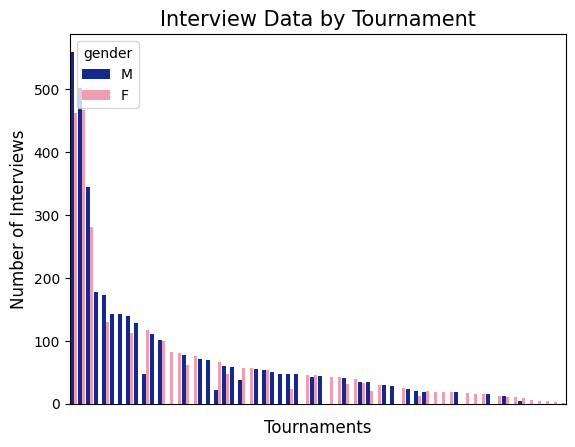

In [42]:
tournaments_df = transcripts_df.groupby(by=['tournament', 'gender'])[['QandA']].count().reset_index()
tournaments_df = tournaments_df.sort_values(by='QandA', ascending=False)

# Tournament Frequencies
g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA', hue='gender',
                 hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament', fontsize = 15)

# Display the plot
plt.show()

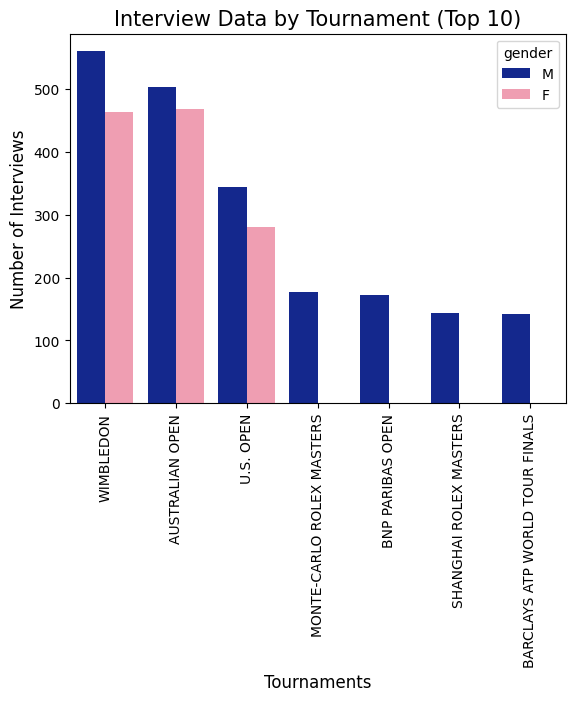

In [43]:
# The players with the most commentaries (10 most)
tournaments_df = tournaments_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA',
                 hue='gender', hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament (Top 10)', fontsize = 15)

# Display the plot
plt.show()

### Get answers in terms of gender as two lists of words

In [44]:
male_transcripts_df = transcripts_df[transcripts_df['gender'] == 'M']
female_transcripts_df = transcripts_df[transcripts_df['gender'] == 'F']

male_answers = []
for interview in male_transcripts_df['QandA'].to_list():
  for qna in interview:
    male_answers.append(qna[1])

female_answers = []
for interview in female_transcripts_df['QandA'].to_list():
  for qna in interview:
    female_answers.append(qna[1])

split_words = [words.split() for words in male_answers]
male_words = [word for words in split_words for word in words]

split_words = [words.split() for words in female_words]
female_words = [word for words in split_words for word in words]

### Interview Answers Word Clouds by Gender

-------------------------------------------------------------------
Male Frequency Mean: 112.03877585056705
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 1029.2522722381398
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 21889
Female Word Count: 21889
-------------------------------------------------------------------


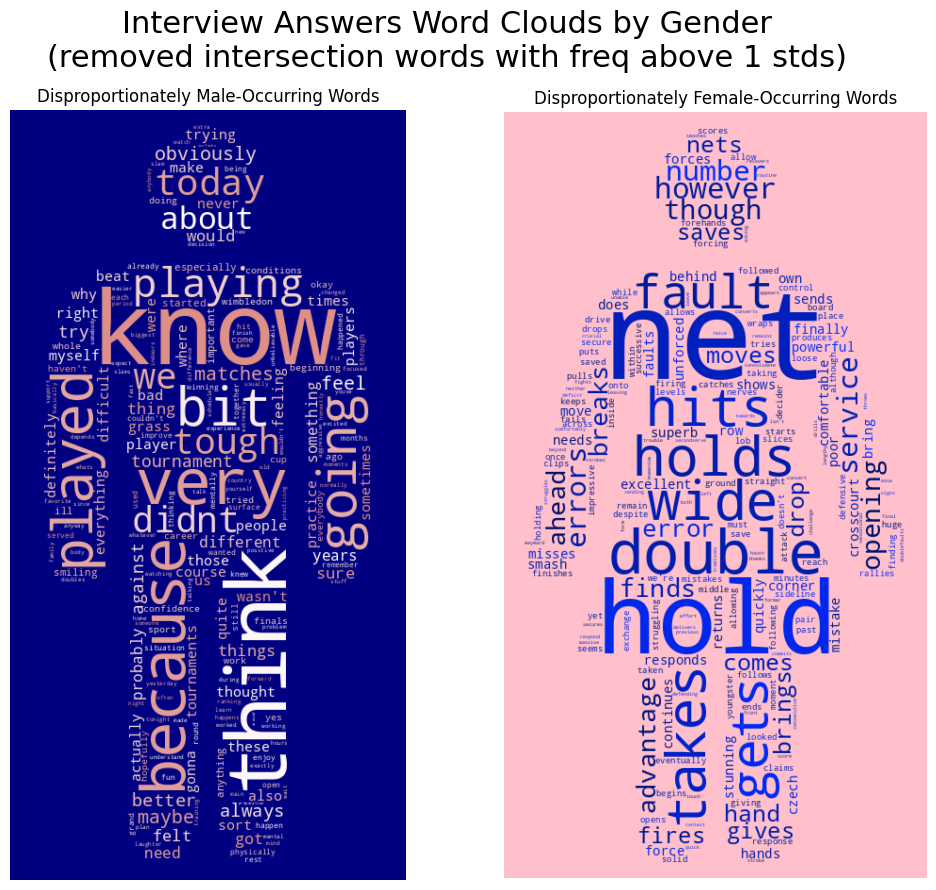

In [45]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 1, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 112.03877585056705
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 1029.2522722381398
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 10927
Female Word Count: 10927
-------------------------------------------------------------------


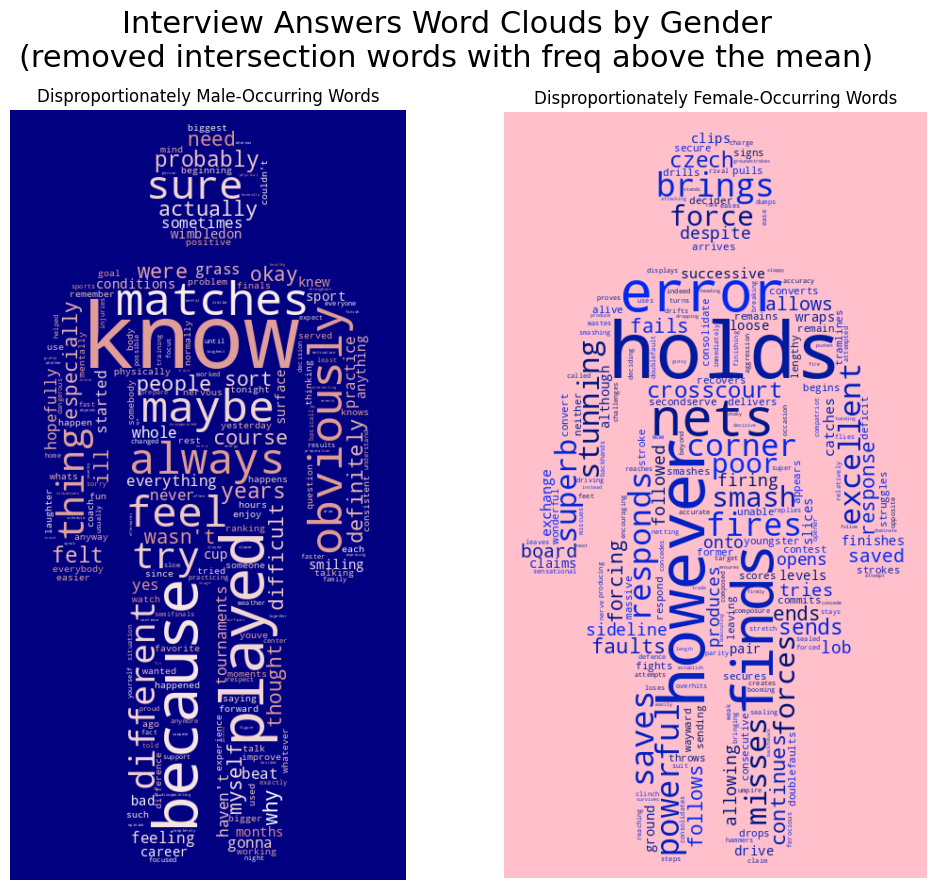

In [46]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 0, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 112.03877585056705
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 1029.2522722381398
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 1355
Female Word Count: 1355
-------------------------------------------------------------------


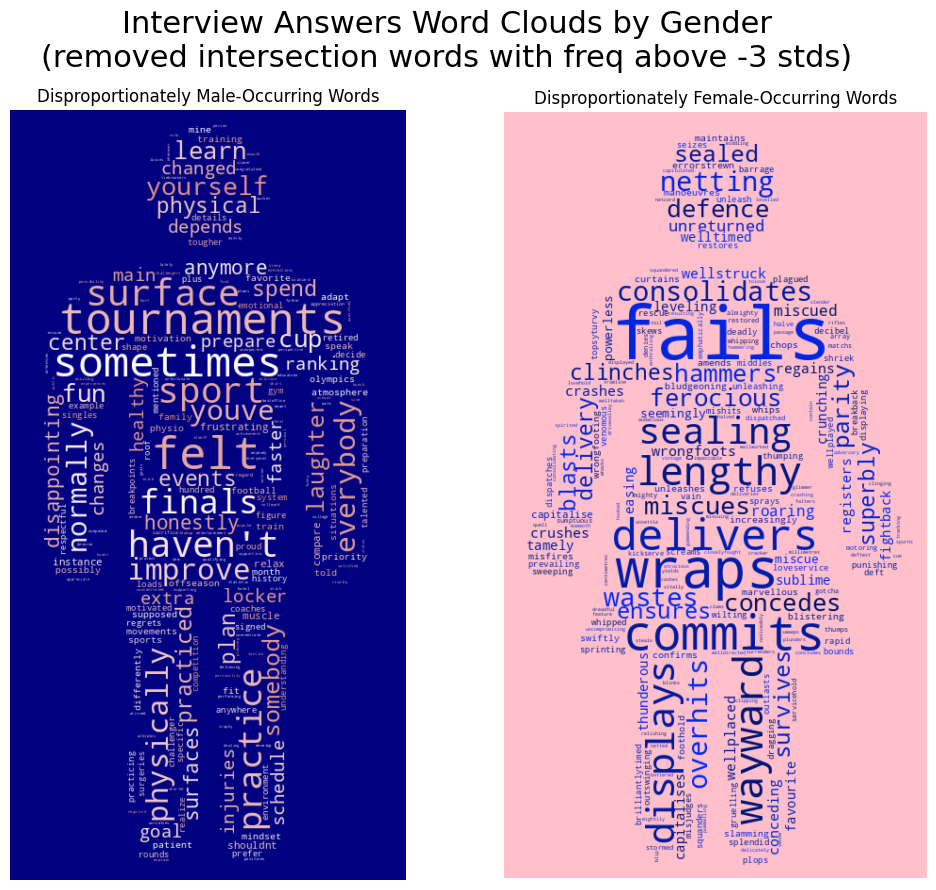

In [47]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, -3, 'Interview Answers')

### Interview Answers Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.63
-------------------------------------------------------------------
Female Percentage of Words Included: 0.78
-------------------------------------------------------------------


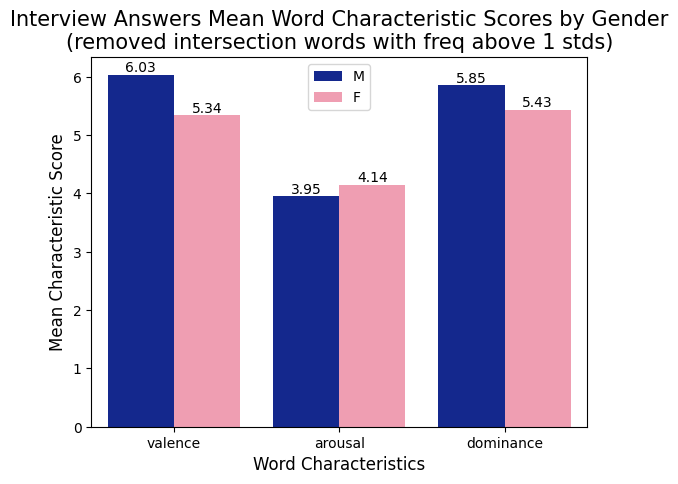

In [48]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's commentary, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         1, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.67
-------------------------------------------------------------------
Female Percentage of Words Included: 0.74
-------------------------------------------------------------------


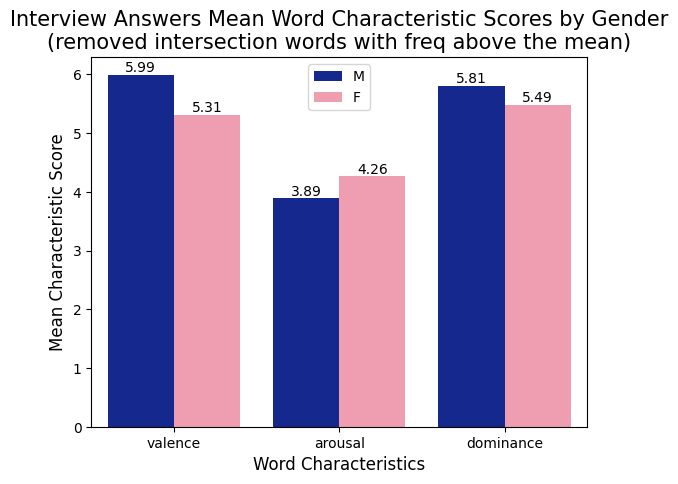

In [49]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         0, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.71
-------------------------------------------------------------------
Female Percentage of Words Included: 0.58
-------------------------------------------------------------------


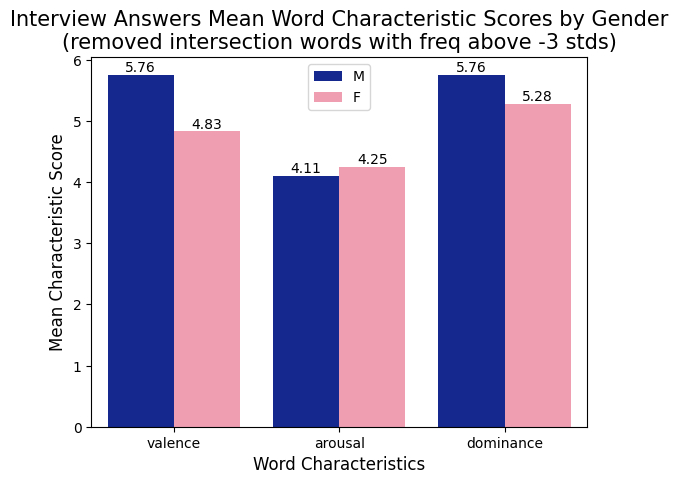

In [50]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         -3, 'Interview Answers')

## Establishing Baselines

### Simple Baseline: Similar top words for male & female tennis players.

Our simple baseline will be a similarity score between the top words for male & female tennis players. To calculate this, we will extract the 30 most common words for both groups and then compare the number of those top 30 words that are related to tennis. This is a similar simple baseline to the one established early in the paper we aim to recreate.

In [51]:
male_words = male_text.split()
female_words = female_text.split()

In [52]:
import re
from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords
import nltk

# Download the stopwords resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

-------------------------------------------------------------------
Male Frequency Mean: 12.803529803529804
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 61.06285304645142
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 17306
Female Word Count: 17306
-------------------------------------------------------------------


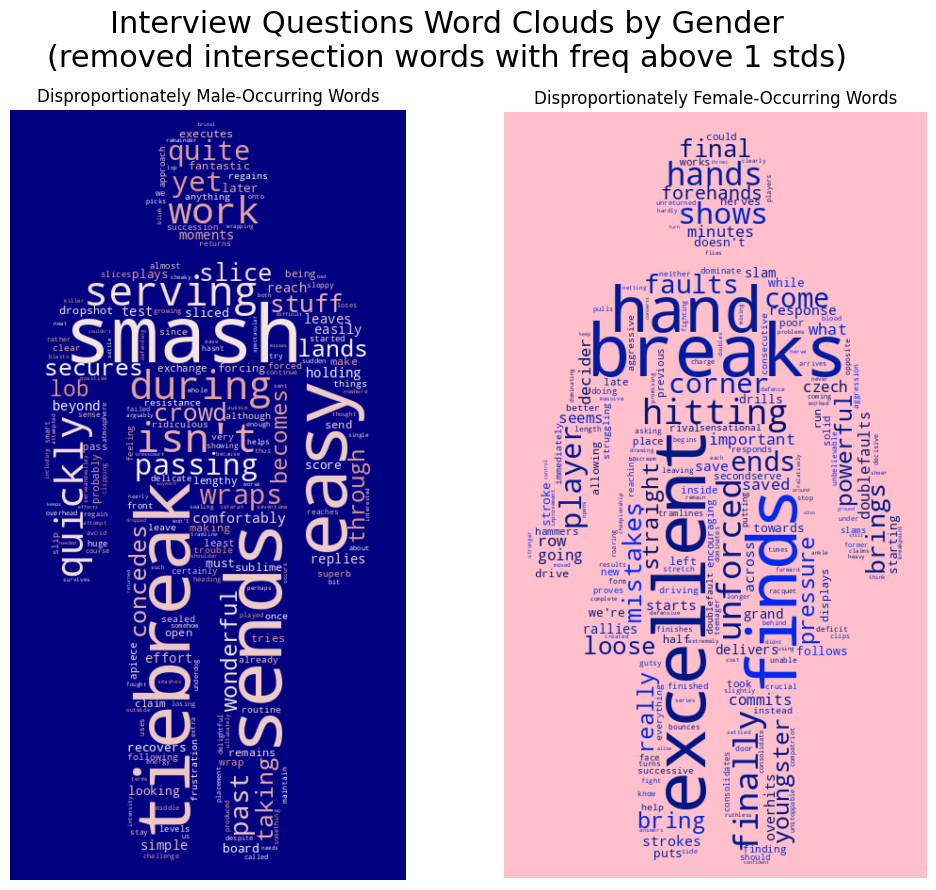

In [53]:
(male_elements, female_elements), (male_counter_red, female_counter_red), (male_diff_list, female_diff_list) = get_diff_words(male_words, female_words, remove_words, 1, 'Interview Questions')

In [54]:
def get_top_30_sorted_tuples(diff_list):
    # Sort the list of tuples in descending order based on the second element (count)
    sorted_list = sorted(diff_list, key=lambda x: x[1], reverse=True)

    # Return the first 30 elements
    top_30 = sorted_list[:30]

    return top_30

Use chatGPT to first develop a list of tennis-related words. Then, manually add to this list through research from a dictionary etc. The Paper 0 methodology involved actually using the commentary data to determine tennis-related words. In this simple baseline, we will use this list as our determinant of tennis-related words.

ChatGPT prompt:

```
# You are a tennis commentator for the world's most elite athletes.
#We are building a language model to understand tennis commentary better.
#Give me a list of all the words related to tennis that we should consider
#when building a model to detect tennis-related words in commentary and tennis player post-match, pre-match interviews.
```



In [55]:
tennis_related_words = [
    # Player-Specific Terms
    "player", "singles", "doubles", "opponent", "contender", "challenger", "world", "no", "1", "secures", "hands", "mistakes", "fault", "faults"

    # Match and Game Terms
    "match", "game", "set", "point", "tiebreak", "break", "serve", "volley", "rally", "net", "baseline", "advantage", "deuce", "game", "set", "match", "breaks", "hitting"

    # Tournament and Event Terms
    "grand", "slam", "atp", "wta", "major", "championship", "slam", "masters", "davis", "cup", "fed", "finals", "qualifier", "wildcard",

    # Court and Surface Terms
    "court", "surface", "clay", "grass", "hardcourt", "indoor", "outdoor", "plexicushion", "decoturf", "lands", "sends"

    # Skill and Technique Terms
    "forehand", "forehands", "backhand", "serve", "serving", "volley", "slice", "topspin", "drop", "lob", "smash", "approach", "passing", "spin", "power", "lands", "smash"

    # Equipment and Gear Terms
    "racket", "strings", "grip", "tennis", "ball", "racquet", "bag", "court", "shoes", "apparel", "gear", "kit",

    # Officials and Rules Terms
    "umpire", "chair", "umpire", "line", "judge", "hawk-eye", "challenge", "code", "violation", "let", "net", "cord", "foot", "fault", "double", "fault",

    # Ranking and Seeding Terms
    "ranking", "seed", "world", "number", "one", "top", "seed", "wildcard", "challenger", "qualifier", "round-robin", "concedes"

    # Performance and Strategy Terms
    "ace", "double", "fault", "strategy", "tactics", "mental", "toughness", "fitness", "endurance", "stamina", "speed", "precision", "decider",

    # Achievements and Records Terms
    "grand", "slam", "title", "career", "slam", "golden", "slam", "record", "milestone", "hall", "fame", "winning", "streak", "crowd",

    # Interview and Commentary Terms
    "interview", "commentator", "recap", "prediction", "post-match", "pre-match"
]

# Test print to verify the list
print(tennis_related_words)


['player', 'singles', 'doubles', 'opponent', 'contender', 'challenger', 'world', 'no', '1', 'secures', 'hands', 'mistakes', 'fault', 'faultsmatch', 'game', 'set', 'point', 'tiebreak', 'break', 'serve', 'volley', 'rally', 'net', 'baseline', 'advantage', 'deuce', 'game', 'set', 'match', 'breaks', 'hittinggrand', 'slam', 'atp', 'wta', 'major', 'championship', 'slam', 'masters', 'davis', 'cup', 'fed', 'finals', 'qualifier', 'wildcard', 'court', 'surface', 'clay', 'grass', 'hardcourt', 'indoor', 'outdoor', 'plexicushion', 'decoturf', 'lands', 'sendsforehand', 'forehands', 'backhand', 'serve', 'serving', 'volley', 'slice', 'topspin', 'drop', 'lob', 'smash', 'approach', 'passing', 'spin', 'power', 'lands', 'smashracket', 'strings', 'grip', 'tennis', 'ball', 'racquet', 'bag', 'court', 'shoes', 'apparel', 'gear', 'kit', 'umpire', 'chair', 'umpire', 'line', 'judge', 'hawk-eye', 'challenge', 'code', 'violation', 'let', 'net', 'cord', 'foot', 'fault', 'double', 'fault', 'ranking', 'seed', 'world',

In [56]:
top_30_female = get_top_30_sorted_tuples(female_diff_list)

In [57]:
top_30_male = get_top_30_sorted_tuples(male_diff_list)

In [58]:
def calculate_tennis_simple_percentage(diff_list, tennis_related_words):
    # Convert tennis_related_words to a set for faster membership testing
    tennis_related_set = set(tennis_related_words)

    # Calculate the total number of words in diff_list
    total_words = sum(count for _, count in diff_list)

    # Calculate the number of tennis-related words in diff_list
    tennis_related_count = sum(count for word, count in diff_list if word.lower() in tennis_related_set)

    # Calculate the percentage of tennis-related words
    percentage_tennis_related = (tennis_related_count / total_words) * 100 if total_words > 0 else 0

    return percentage_tennis_related

In [59]:
male_question_perc_tennis_top30 = calculate_tennis_simple_percentage(top_30_male, tennis_related_words)
male_question_perc_tennis_top30

32.7922077922078

In [60]:
female_question_perc_tennis_top_30 = calculate_tennis_simple_percentage(top_30_female, tennis_related_words)
female_question_perc_tennis_top_30

19.210526315789473

This serves as a simple baseline. We see that men have more words than women that are directly tennis related when looking at the top 30 ngrams for questions asked to both women and men.

### Exploration of Topic Modelling

From the cleaned questions dataset, we can generate topics for each question using LDA. The goal is to generate a column in the dataset with a topic and theme. This way, we can explore whether the themes and topics asked to female athletes differ from those asked to male athletes.

First, we check that we have the cleaned questions version of the dataset. And then we want to save the cleaned questions dataset to our drive, so we can easily access it without preprocessing again.

In [61]:
questions_df_cleaned.head()

player gender  result  \
0  andy murray      M       1   
0  andy murray      M       1   
0  andy murray      M       1   
0  andy murray      M       1   
0  andy murray      M       1   

                                           questions  ranking  
0  That last set seemed like a faultless performa...      3.0  
0  Did playing the semifinal, finishing that off ...      3.0  
0  Is that difficult mentally as much as physical...      3.0  
0  You said on TV I think you said you felt bette...      3.0  
0  The last time that you won this tournament you...      3.0

In [63]:
questions_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81933 entries, 0 to 6466
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     81933 non-null  object 
 1   gender     81933 non-null  object 
 2   result     81933 non-null  int64  
 3   questions  81933 non-null  object 
 4   ranking    81908 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.8+ MB


In [64]:
file_path = '/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/questions_df_cleaned.csv'

questions_df_cleaned.to_csv(file_path, index=False)

# Confirm that the file has been created
print(f'DataFrame has been written to {file_path}')

DataFrame has been written to /content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/questions_df_cleaned.csv


#### Exploring LDA on the whole dataset

In [66]:
import re, nltk, spacy, string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# import pyLDAvis
# import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

In [67]:
vectorizer = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized = vectorizer.fit_transform(questions_df_cleaned['questions'])

lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

In [69]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Assuming you have already defined vectorizer, data_vectorized, lda_model, and lda_output as described in your question

# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d" % (topic_idx)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Set the number of top words you want to display for each topic
no_top_words = 20

# Display the top words for each topic
top_words_df = display_topics(lda_model, feature_names, no_top_words)

# Print the top words for each topic
print(top_words_df)


       Topic 0      Topic 1   Topic 2   Topic 3      Topic 4   Topic 5  \
0        match          bit      year     level         like      time   
1         talk       little      said  thoughts          lot     years   
2         slam         good     final    couple       pretty    coming   
3        grand          got     roger    serena       people     right   
4          did        great  thinking    saying        tough      long   
5       points       moment     nadal       hit         lose    better   
6         lost     pressure   doubles     haven      explain       ago   
7   confidence         work     world     think         life     start   
8      tonight  tournaments  djokovic      just      pleased   getting   
9        close        think   earlier   ranking         stay     think   
10        sets          try    finals    making         high      past   
11       watch       trying      love   chances     watching    injury   
12     started   especially     makes 

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn import metrics

import numpy as np

# Assuming you have already defined vectorizer, data_vectorized, lda_model as described in your question
# Also, assuming questions_df_cleaned is your original DataFrame containing the preprocessed text data

# Convert the data_vectorized matrix to a list of preprocessed documents
documents = questions_df_cleaned['questions'].tolist()

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Function to calculate topic uniqueness
def calculate_topic_uniqueness(lda_model):
    cosine_similarities = cosine_similarity(lda_model.components_)
    return 1 - cosine_similarities.mean()

# Calculate and print topic uniqueness
topic_uniqueness = calculate_topic_uniqueness(lda_model)
print(f'Topic Uniqueness: {topic_uniqueness:.4f}')

Topic Uniqueness: 0.9266


In [79]:
import numpy as np

# Make a copy of the DataFrame to avoid modifying it in place
questions_df_cleaned_copy = questions_df_cleaned.copy()

# Get the most likely topic for each question
most_likely_topic = np.argmax(lda_output, axis=1)

# Add the new column to the copied DataFrame
questions_df_cleaned_copy['most_likely_topic'] = most_likely_topic

questions_df_cleaned = pd.DataFrame(questions_df_cleaned_copy)
questions_df_cleaned

player gender  result  \
0           andy murray      M       1   
0           andy murray      M       1   
0           andy murray      M       1   
0           andy murray      M       1   
0           andy murray      M       1   
...                 ...    ...     ...   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   

                                              questions  ranking  \
0     That last set seemed like a faultless performa...      3.0   
0     Did playing the semifinal, finishing that off ...      3.0   
0     Is that difficult mentally as much as physical...      3.0   
0     You said on TV I think you said you felt bette...      3.0   
0     The last time that you won this tournament you...      3.0   
...                                                 ...      ...   
6466  Tennis is sometimes described as a profession,...      8.0   
6466  Last year's champion is really into art. Who a...      8.0   
6466  You touched on your support of Argentina. How ...      8.0   
6466     Do you think Wimbledon does that to an extent?      8.0   
6466  What goes through your mind when you watch Messi?      8.0   

      most_likely_topic  
0                    17  
0                    10  
0                    14  
0                    13  
0                     6  
...                 ...  
6466                  5  
6466                  2  
6466                 15  
6466                  9  
6466                 14  

[81933 rows x 6 columns]

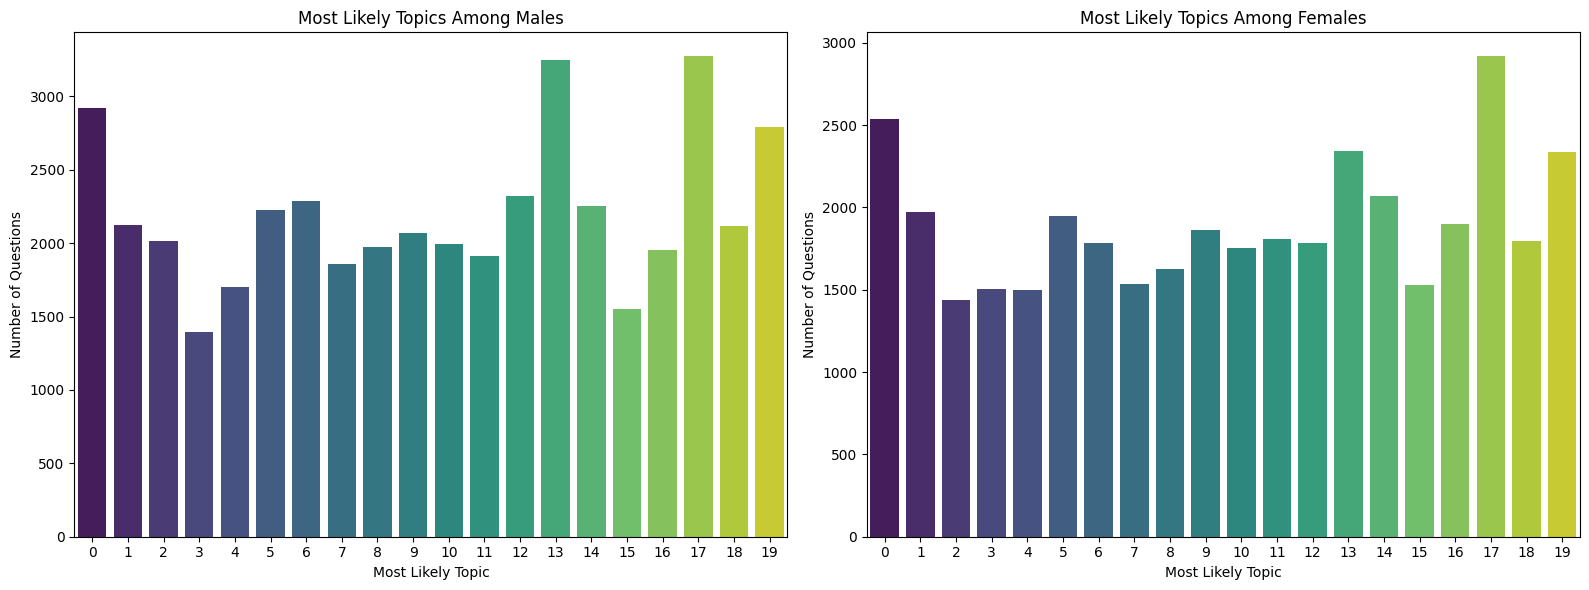

In [81]:

# Create separate DataFrames for males and females
males_df = questions_df_cleaned[questions_df_cleaned['gender'] == 'M']
females_df = questions_df_cleaned[questions_df_cleaned['gender'] == 'F']

# Count the occurrences of each topic for males and females
male_topic_counts = males_df['most_likely_topic'].value_counts()
female_topic_counts = females_df['most_likely_topic'].value_counts()

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Bar plot for males
sns.barplot(x=male_topic_counts.index, y=male_topic_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Most Likely Topics Among Males')
axes[0].set_xlabel('Most Likely Topic')
axes[0].set_ylabel('Number of Questions')

# Bar plot for females
sns.barplot(x=female_topic_counts.index, y=female_topic_counts.values, ax=axes[1], palette='viridis')
axes[1].set_title('Most Likely Topics Among Females')
axes[1].set_xlabel('Most Likely Topic')
axes[1].set_ylabel('Number of Questions')

# Adjust layout
plt.tight_layout()
plt.show()


In [84]:
from scipy.stats import chi2_contingency

In [85]:
# Get the most likely topic for each question
most_likely_topic = np.argmax(lda_model.transform(data_vectorized), axis=1)

# Add the new column to the DataFrame
questions_df_cleaned['most_likely_topic'] = most_likely_topic

# Create a contingency table
contingency_table = pd.crosstab(questions_df_cleaned['most_likely_topic'], questions_df_cleaned['gender'])

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Print the p-value
print(f"Chi-squared test p-value: {p}")

Chi-squared test p-value: 1.101046123168575e-29


In [87]:
contingency_table

gender                F     M
most_likely_topic            
0                  2538  2917
1                  1970  2123
2                  1441  2013
3                  1505  1392
4                  1500  1698
5                  1948  2225
6                  1787  2290
7                  1535  1859
8                  1624  1971
9                  1866  2072
10                 1756  1995
11                 1806  1914
12                 1786  2320
13                 2345  3250
14                 2068  2250
15                 1528  1551
16                 1902  1955
17                 2918  3272
18                 1799  2115
19                 2338  2791

In [91]:
total_female_asked_questions = contingency_table['F'].sum()
total_male_asked_questions = contingency_table['M'].sum()

In [94]:
# these are vastly different. We will make this a proportion table rather than a frequency table.
contingency_table_proportions = contingency_table.copy()
contingency_table_proportions['F'] = contingency_table_proportions['F'] / total_female_asked_questions
contingency_table_proportions['M'] = contingency_table_proportions['M'] / total_male_asked_questions

In [95]:
contingency_table_proportions

gender                    F         M
most_likely_topic                    
0                  0.066860  0.066336
1                  0.051897  0.048280
2                  0.037961  0.045778
3                  0.039647  0.031656
4                  0.039515  0.038615
5                  0.051317  0.050599
6                  0.047076  0.052077
7                  0.040437  0.042276
8                  0.042782  0.044823
9                  0.049157  0.047120
10                 0.046259  0.045369
11                 0.047576  0.043527
12                 0.047050  0.052760
13                 0.061776  0.073909
14                 0.054478  0.051168
15                 0.040253  0.035272
16                 0.050105  0.044459
17                 0.076870  0.074409
18                 0.047392  0.048098
19                 0.061591  0.063471

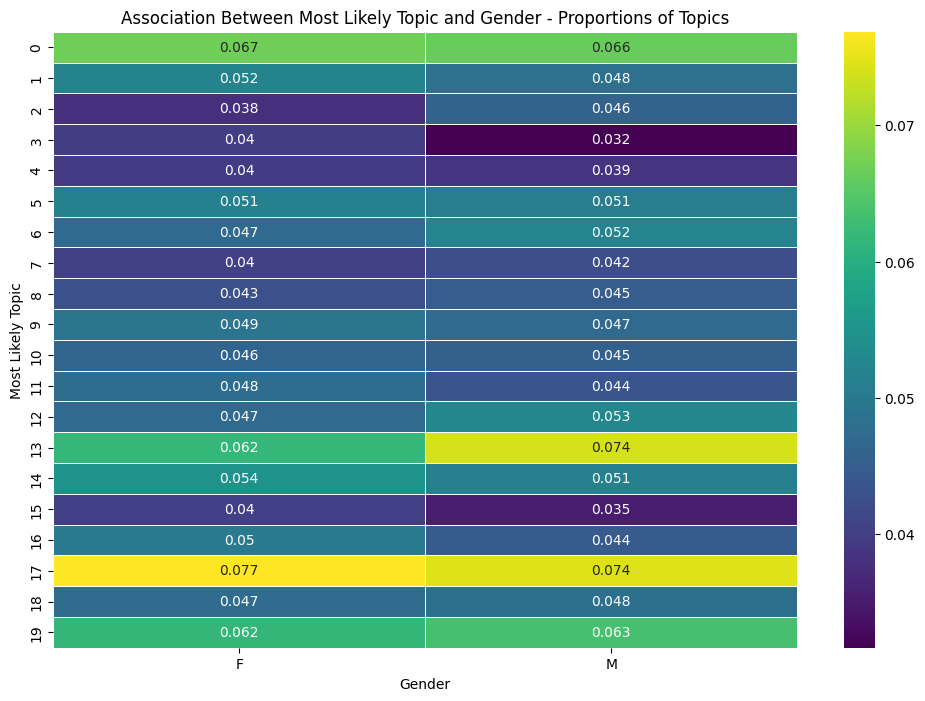

In [99]:
# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table_proportions, annot=True, cmap="viridis", cbar=True, linewidths=.5)
plt.title('Association Between Most Likely Topic and Gender - Proportions of Topics')
plt.xlabel('Gender')
plt.ylabel('Most Likely Topic')
plt.show()


In [165]:
def get_top_words(lda_model, vectorizer, n_words=20):
    words = vectorizer.get_feature_names_out()
    topics = []
    top_words = []
    frequencies = []

    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = topic.argsort()[:-n_words - 1:-1]
        topic_words = [words[idx] for idx in top_word_indices]
        topic_frequencies = topic[top_word_indices]

        topics.extend([f"Topic {topic_idx + 1}"] * n_words)
        top_words.extend(topic_words)
        frequencies.extend(topic_frequencies)

    df = pd.DataFrame({'Topic': topics, 'Word': top_words, 'Frequency': frequencies})
    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [105]:
import pandas as pd

# Assuming lda_model is your fitted LDA model
# Assuming vectorizer is your CountVectorizer used for LDA model

# Function to get top words and their frequencies for each topic
def get_top_words(lda_model, vectorizer, n_words=20):
    words = vectorizer.get_feature_names_out()
    topics = []
    top_words = []
    frequencies = []

    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = topic.argsort()[:-n_words - 1:-1]
        topic_words = [words[idx] for idx in top_word_indices]
        topic_frequencies = topic[top_word_indices]

        topics.extend([f"Topic {topic_idx + 1}"] * n_words)
        top_words.extend(topic_words)
        frequencies.extend(topic_frequencies)

    df = pd.DataFrame({'Topic': topics, 'Word': top_words, 'Frequency': frequencies})
    return df

# Get top words and their frequencies for each topic
top_words_df = get_top_words(lda_model, vectorizer, n_words=20)

# Display the dataframe
print(top_words_df)


        Topic         Word    Frequency
0     Topic 1        match  9574.597946
1     Topic 1         talk  3786.901510
2     Topic 1         slam  1606.603756
3     Topic 1        grand  1541.598357
4     Topic 1          did  1521.984332
..        ...          ...          ...
395  Topic 20  comfortable   416.569355
396  Topic 20    wimbledon   412.313435
397  Topic 20        enjoy   407.372628
398  Topic 20       season   397.709916
399  Topic 20        extra   333.650681

[400 rows x 3 columns]


In [117]:
top_words_df = pd.DataFrame(top_words_df)
top_words_df_3 =top_words_df[ top_words_df['Topic'] == 'Topic 3']

In [118]:
top_words_df_3

Topic      Word    Frequency
40  Topic 3      year  5810.977782
41  Topic 3      said  2587.131047
42  Topic 3     final  1796.155791
43  Topic 3     roger   980.681850
44  Topic 3  thinking   813.682686
45  Topic 3     nadal   695.887426
46  Topic 3   doubles   689.969841
47  Topic 3     world   647.438229
48  Topic 3  djokovic   482.883738
49  Topic 3   earlier   476.726020
50  Topic 3    finals   442.719039
51  Topic 3      love   411.603261
52  Topic 3     makes   400.082923
53  Topic 3   overall   340.473550
54  Topic 3      deal   333.039881
55  Topic 3   prepare   321.367668
56  Topic 3     money   277.575989
57  Topic 3  feelings   263.184618
58  Topic 3   beating   253.207389
59  Topic 3      hear   251.245372

In [127]:
questions_df_cleaned_male = questions_df_cleaned[questions_df_cleaned['gender'] == 'M']
questions_df_cleaned_female = questions_df_cleaned[questions_df_cleaned['gender'] == 'F']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [128]:
len(questions_df_cleaned_female)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



37960

In [129]:
len(questions_df_cleaned_male)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



43973

#### Train Separate LDA models on Males, Females

In [131]:
data_vectorized_female = vectorizer.fit_transform(questions_df_cleaned_female['questions'])

lda_model_female = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_female = lda_model_female.fit_transform(data_vectorized_female)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [137]:
vectorizer_female = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_female = vectorizer_female.fit_transform(questions_df_cleaned_female['questions'])

lda_model_female = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_female = lda_model_female.fit_transform(data_vectorized_female)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [136]:

top_words_df_female = display_topics(lda_model_female, feature_names, no_top_words)
top_words_df_female


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0     Topic 1      Topic 2       Topic 3     Topic 4  \
0            yell         god      tallest        master      direct   
1         playoff   mccartney      yelling    difficulty         row   
2         playing        work     dominant          says         car   
3           match       world          ago      thoughts       years   
4        thousand  turnaround       master          fell    grueling   
5         granted   statistic        miles         quote      memory   
6      tipsarevic        idea      whatnot         scale   retriever   
7         seasons     fighter       change  surroundings         toe   
8       connected    meetings         past       changed      golden   
9       obviously       rosol       lining     limelight  birmingham   
10          beats    studying  explanation          hole  physically   
11        grandma    comeback       marian     sensation    outright   
12          close       lived       austin     spectator        hair   
13          curse      unfair       physio       usually      fourth   
14  traditionally        sake       limits          luck      agency   
15           wind    stressed       rarely           man  marseilles   
16            won     atlanta        shall        points     include   
17         mature   handshake      playing           far    coaching   
18       cramping     medical         sell        asking     stamina   
19          class     olympic     personal        fitter     motions   

        Topic 5    Topic 6     Topic 7       Topic 8    Topic 9      Topic 10  \
0        lining   weakness       dokic        engage      lance  gamesmanship   
1     feliciano     window      weight           dig       term      thousand   
2         plays     points     comment        losses        low        recall   
3   traditional       lost    mallorca          said       door          slam   
4        master   actually  hantuchova     direction     lining      gracious   
5        better        low     inspire       tempted        90s           won   
6       serbian      asked  earthquake       station     happen          gets   
7         dokic   suffered     working  threesetters   thousand          tape   
8        towels  forgotten     planned        lining    players          told   
9       version       ward     rethink       doubles      women     champions   
10       father      video      carlos           men  awareness        golfer   
11      playing     golfer      runner         water     recall       belarus   
12    topranked     winter      heroes         needs    heavier          kiss   
13     cramping   conserve    retiring        lounge   congrats    challenged   
14    limelight    talking    affected        nelson       wave     structure   
15         said     single    matchups        manage   cramping     advantage   
16       monkey  anastasia   obviously    aggression       come    tremendous   
17    surprised      chang   headlines     incidents       fast        roller   
18     finalist  traveling        fair          girl     source           gas   
19         lets      windy        quit     schedules   memories         glory   

      Topic 11       Topic 12     Topic 13       Topic 14     Topic 15  \
0      serving         called      oncourt          death        tomas   
1         blah   performances       mature          threw       master   
2         long        feature         peng           wind        loser   
3     secondly            pro        opens          slams     thousand   
4       billie    comparisons     handling  participating   hardcourts   
5       lining         hardly    pressures     whatsoever      coached   
6       poland       pleasure     thousand        sitting  impressions   
7       loving        servers          dip      wondering       traded   
8         good            gal    thousands      expressed       window   
9     thousand  entertainment         yell       moveme

In [139]:
vectorizer_male = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_male = vectorizer_male.fit_transform(questions_df_cleaned_male['questions'])

lda_model_male = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_male = lda_model_male.fit_transform(data_vectorized_male)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [140]:
top_words_df_male = display_topics(lda_model_male, feature_names, no_top_words)
top_words_df_male

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0        Topic 1      Topic 2      Topic 3     Topic 4  \
0          rush        created     bjorkman        watch     cutting   
1       william          groin        teams  preferences   melbourne   
2   opportunity        helping         loud   teamtennis      debate   
3          bits       dimitrov      tighter        enemy     offense   
4   lowerranked       climbing    scheduled      highest      senior   
5          woke         listen   evaluation        doing       talks   
6    commitment          halep         face       growth       carlo   
7         peers         charge        flare    technical     helpful   
8          tear      obstacles        black      charity       doesn   
9       sponsor       accurate      chances   kleybanova       groin   
10      teenage           lots    benefited       safina  phenomenal   
11       finish         credit       loving    hardcourt    pressure   
12        gates        college  lowerranked        robin      listen   
13     backhand     expressing        lucky      glamour        hurt   
14   background   higherranked  australians        level     mikhail   
15         wine        theater        fancy      hisense       large   
16          ran      scheduled      decided        small        bang   
17      wildest    lowerranked     ordinary       golden  presumably   
18         park  strategically        mouth         sock  nightmares   
19       nearly         thomas         poor      belgian         atp   

       Topic 5     Topic 6     Topic 7      Topic 8      Topic 9  \
0        years       pizza      places         said       placed   
1       reward      listen     wearing          cup  financially   
2        loses   placement       fixed   federation       theory   
3      lindsay         dig   teenagers       worked        lower   
4     cramping      places    behavior       yellow     campaign   
5         tear      volume    thrilled     altitude       nearly   
6        alter      nicole        tear          pin       listen   
7        pulls   extremely   confusing        small   earthquake   
8      theater     adopted    thoughts  springboard         vary   
9         past       times      doctor       warmup      belarus   
10     sailing       large   pressures        peers        speed   
11         mri  kleybanova        real    sarcastic        heavy   
12     section       doesn        time       liking       lesser   
13    pospisil    trainers      robert        space       german   
14     mandela      double        rafa   kleybanova        strap   
15  characters     theater  dominating       gamble    dimension   
16  kazakhstan     website     largely       surely      threats   
17  commitment   defending      caused     balanced        joked   
18      inside  motivation  kleybanova  exceptional       stacey   
19     raining    occasion         hug     grinding      younger   

        Topic 10     Topic 11      Topic 12        Topic 13     Topic 14  \
0          semis     mattered          year          growth       mature   
1      schiavone       differ          tear       guarantee       sights   
2         player        surge      timeouts           final          gym   
3     manchester       listen         place          robert       decade   
4          halle   difference      answered        mobility         heck   
5        playing     thoughts      quantify            bali          lot   
6   difficulties         tear         birth           based         hasn   
7     dominating      lacking   navratilova         trainer         warm   
8         listen  commentator        window          midway        groin   
9         breeze   kleybanova       wildest          planet        young   
10         weird  lowerranked          feed         compete         tear   
11           yes      tighter  characterize           konta        doesn   
12     surgeries      petrova        relate           doesn        loves   
13

While the TU score is not bad, we want to think through the fact that these topics just from a lamens view, don't appear coherent. Let's see what it looks like when we increase the number of topics:

In [149]:
vectorizer_female = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_female = vectorizer_female.fit_transform(questions_df_cleaned_female['questions'])

lda_model_female = LatentDirichletAllocation(n_components=40, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_female = lda_model_female.fit_transform(data_vectorized_female)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [150]:
top_words_df_female = display_topics(lda_model_female, feature_names, no_top_words)
top_words_df_female

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0       Topic 1        Topic 2       Topic 3     Topic 4  \
0       lining         world           yell       serbian       risen   
1          war         wrote          match    challenged       scale   
2      thought          kids        coached      outright        hole   
3       poland          hair         change         rosol       years   
4         kick        gilles    impressions      comeback   spectator   
5      players        joined       thousand       atlanta         man   
6        quick        jewish          curse       medical       older   
7       czechs  straightsets  traditionally      lopsided  youngsters   
8        asked       perfect           told       exploit      roller   
9       effect   partnership           fast        wonder         gas   
10     feeling       madison        playing        robson   excellent   
11    official          held          wuhan       walking  reasonable   
12       short          link         turned          asia   specifics   
13  approaches      colombia     birmingham       seeding       dutch   
14        wins   competitors       supposed    contenders     mcilroy   
15        pick        safina      anastasia         storm   dominance   
16     measure      wondered            son        linked     careers   
17     quickly       invited       sticking         trick  maintained   
18        rush         henin      headlines  improvements     studies   
19      asleep      starting            try        videos       sleep   

      Topic 5        Topic 6        Topic 7        Topic 8          Topic 9  \
0      billie         golfer         master   gamesmanship            death   
1        come      knowledge        tallest           gets            women   
2        peng  participation        whatnot           tape        topranked   
3   direction        servers         marian           kiss         gamewise   
4      happen        prepare        playing  doublefaulted          heavier   
5         lot        succeed         austin        heading             wave   
6        kick         worked          shall       evidence            ethic   
7         low           seek        matches      operation          willing   
8    thousand       winnings       backhand         speech         memories   
9       draws           yale        reverse          rowdy            yonex   
10   congrats      certainly         riding         pounds          surgery   
11    forward         opened         office          japan        incidents   
12  obviously    challenging         commit         feared        structure   
13  retriever        farther      strapping          pulls        courtside   
14        aim      magnitude       struggle         agreed           unfair   
15     healed        members  international        journey  straightforward   
16  feliciano         genius          gives        satisfy       indicating   
17        far            los           pump           want      springboard   
18     reason      returners      qualified        aspects            mount   
19      loved         sights      household       increase         intimate   

    ...   Topic 30    Topic 31    Topic 32     Topic 33      Topic 34  \
0   ...     recall    grueling       plays         term      cramping   
1   ...    yelling  whatsoever      better        loser        mature   
2   ...        won         toe   limelight        prize        pretty   
3   ...     serena    movement   feliciano         luck       seasons   
4   ...        big     courage     version          gal       grandma   
5   ...   thousand    reaching      physio  surrounding           dip   
6   ...      threw       spins   champions        radek     thousands   
7   ...        ago   postmatch        plan     meetings          kick   
8   ...        car        hong      lovely     momentum  surroundings   
9   ...      top20      cities      length       played      thousand   
10  ...   

In [151]:
topic_uniqueness_female = calculate_topic_uniqueness(lda_model_female)
topic_uniqueness_female

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.9715558712641413

In [152]:
topic_uniqueness_male = calculate_topic_uniqueness(lda_model_male)
topic_uniqueness_male

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.9306880038715599

In [169]:
top_words_df_female = get_top_words(lda_model_female, vectorizer_female, n_words=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [170]:
top_words_df_female

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic       Word    Frequency
0     Topic 1       like  5024.035532
1     Topic 1       want   692.150274
2     Topic 1      thing   535.165001
3     Topic 1     points   532.994268
4     Topic 1       just   439.273905
..        ...        ...          ...
795  Topic 40     murray    52.217228
796  Topic 40       word    50.958623
797  Topic 40     travel    50.751487
798  Topic 40      needs    42.017234
799  Topic 40  champions    39.414990

[800 rows x 3 columns]

In [175]:
top_words_df_female

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic       Word    Frequency
0     Topic 1       like  5024.035532
1     Topic 1       want   692.150274
2     Topic 1      thing   535.165001
3     Topic 1     points   532.994268
4     Topic 1       just   439.273905
..        ...        ...          ...
795  Topic 40     murray    52.217228
796  Topic 40       word    50.958623
797  Topic 40     travel    50.751487
798  Topic 40      needs    42.017234
799  Topic 40  champions    39.414990

[800 rows x 3 columns]

In [188]:
vectorizer_male = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_male = vectorizer_male.fit_transform(questions_df_cleaned_male['questions'])

lda_model_male = LatentDirichletAllocation(n_components=40, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_male = lda_model_male.fit_transform(data_vectorized_male)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [190]:
topwords_df_male = get_top_words(lda_model_male, vectorizer_male, n_words=20)
topwords_df_male

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic      Word    Frequency
0     Topic 1      just  2830.748607
1     Topic 1     happy   489.993703
2     Topic 1     asked   203.165072
3     Topic 1    result   187.563914
4     Topic 1    serves   149.428858
..        ...       ...          ...
795  Topic 40  progress    85.881345
796  Topic 40    streak    82.769750
797  Topic 40    series    70.573003
798  Topic 40    hoping    69.769195
799  Topic 40      fish    59.654153

[800 rows x 3 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



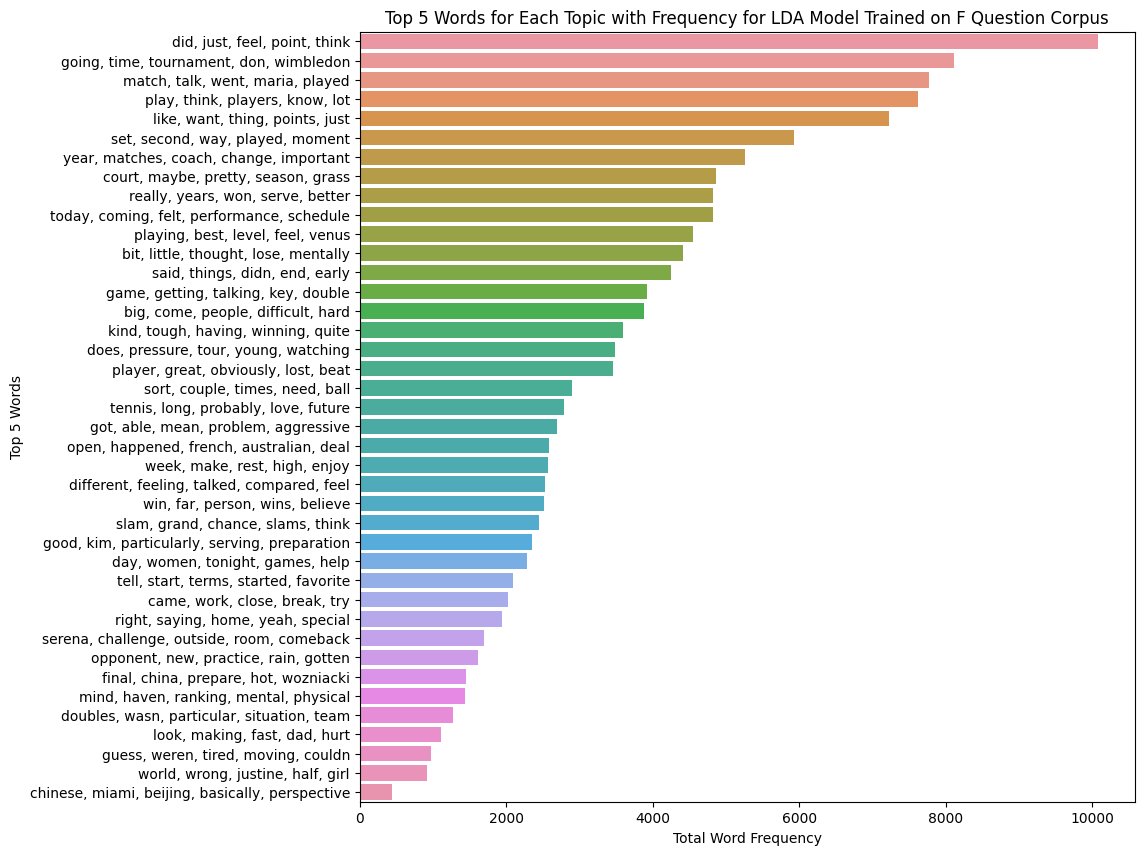

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming top_words_df_female is your DataFrame with 'topic', 'word', and 'frequency' columns

# Extract the top 5 words for each topic
top_words_by_topic = top_words_df_female.groupby('Topic').apply(lambda x: x.nlargest(5, 'Frequency')).reset_index(drop=True)

# Group by topic and aggregate the top 5 words into a list and sum the frequencies
grouped_df = top_words_by_topic.groupby('Topic').agg({'Word': lambda x: list(x), 'Frequency': 'sum'}).reset_index()

# Convert the 'word' column to strings
grouped_df['Word'] = grouped_df['Word'].apply(lambda x: ', '.join(x))

grouped_df = grouped_df.sort_values(by='Frequency', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=grouped_df, dodge=True)

# Set labels and title
plt.xlabel('Total Word Frequency')
plt.ylabel('Top 5 Words')
plt.title('Top 5 Words for Each Topic with Frequency for LDA Model Trained on F Question Corpus')

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



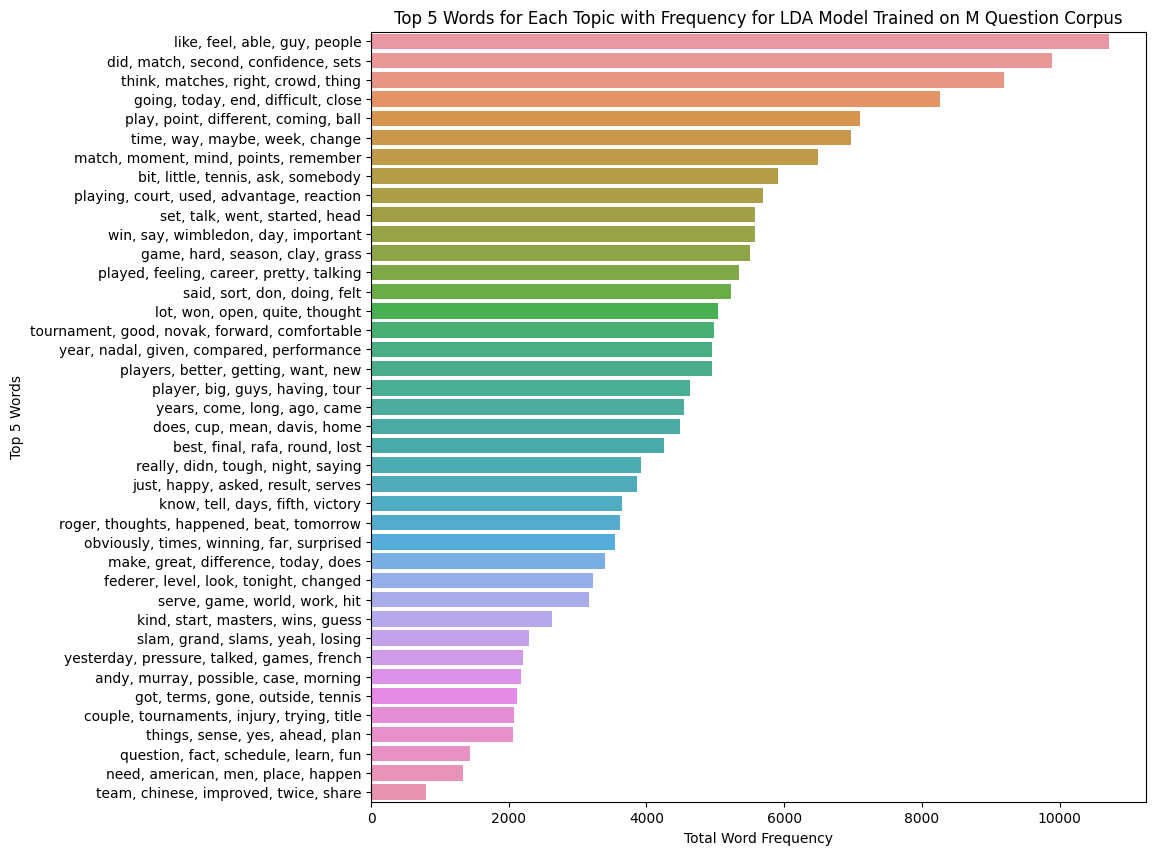

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming top_words_df_female is your DataFrame with 'topic', 'word', and 'frequency' columns

# Extract the top 5 words for each topic
top_words_by_topic_male = topwords_df_male.groupby('Topic').apply(lambda x: x.nlargest(5, 'Frequency')).reset_index(drop=True)

# Group by topic and aggregate the top 5 words into a list and sum the frequencies
grouped_df_male = top_words_by_topic_male.groupby('Topic').agg({'Word': lambda x: list(x), 'Frequency': 'sum'}).reset_index()

# Convert the 'word' column to strings
grouped_df_male['Word'] = grouped_df_male['Word'].apply(lambda x: ', '.join(x))

grouped_df_male = grouped_df_male.sort_values(by='Frequency', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=grouped_df_male, dodge=True)

# Set labels and title
plt.xlabel('Total Word Frequency')
plt.ylabel('Top 5 Words')
plt.title('Top 5 Words for Each Topic with Frequency for LDA Model Trained on M Question Corpus')

# Show the plot
plt.show()

Let's also graphically see the topics n = 20 because this is cool. Let's plot them next to each other.

In [194]:
vectorizer_male = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_male = vectorizer_male.fit_transform(questions_df_cleaned_male['questions'])

lda_model_male = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_male = lda_model_male.fit_transform(data_vectorized_male)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [195]:
vectorizer_female = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_female = vectorizer_female.fit_transform(questions_df_cleaned_female['questions'])

lda_model_female = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_female = lda_model_female.fit_transform(data_vectorized_female)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [196]:
topwords_df_male_20_topics = get_top_words(lda_model_male, vectorizer_male, n_words=20)
topwords_df_male_20_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic       Word    Frequency
0     Topic 1       said  2149.296817
1     Topic 1        win  1663.571383
2     Topic 1       open  1151.112461
3     Topic 1     better   980.948592
4     Topic 1        lot   934.334589
..        ...        ...          ...
395  Topic 20    ranking   246.014231
396  Topic 20     career   238.317892
397  Topic 20       best   229.147954
398  Topic 20       make   219.799068
399  Topic 20  advantage   210.642377

[400 rows x 3 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [197]:
topwords_df_female_20_topics = get_top_words(lda_model_female, vectorizer_female, n_words=20)
topwords_df_female_20_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic      Word    Frequency
0     Topic 1      year  2288.230269
1     Topic 1    player  1283.806526
2     Topic 1    played  1263.932256
3     Topic 1   matches  1169.407069
4     Topic 1     think   784.511919
..        ...       ...          ...
395  Topic 20      nice   176.033159
396  Topic 20      shot   173.220500
397  Topic 20  problems   172.111720
398  Topic 20   hitting   171.401840
399  Topic 20  forehand   170.120647

[400 rows x 3 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Next, let's look at the overall LDA model on n = 40. Let's then label the questions with the most likely topics in each of the F and M datasets. Then, let's have a look at the proportion of each topic in terms of male and female athletes. The idea is to explore whether the *least common topics* are more likely to come up for women than for men.

In [200]:
vectorizer = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized = vectorizer.fit_transform(questions_df_cleaned['questions'])

lda_model = LatentDirichletAllocation(n_components=40, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = 1
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [201]:
# Make a copy of the DataFrame to avoid modifying it in place
questions_df_cleaned_copy = questions_df_cleaned.copy()

# Get the most likely topic for each question
most_likely_topic = np.argmax(lda_output, axis=1)

# Add the new column to the copied DataFrame
questions_df_cleaned_copy['most_likely_topic_40_topics'] = most_likely_topic

questions_df_cleaned = pd.DataFrame(questions_df_cleaned_copy)
questions_df_cleaned

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



player gender  result  \
0           andy murray      M       1   
0           andy murray      M       1   
0           andy murray      M       1   
0           andy murray      M       1   
0           andy murray      M       1   
...                 ...    ...     ...   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   
6466  victoria azarenka      F       1   

                                              questions  ranking  \
0     That last set seemed like a faultless performa...      3.0   
0     Did playing the semifinal, finishing that off ...      3.0   
0     Is that difficult mentally as much as physical...      3.0   
0     You said on TV I think you said you felt bette...      3.0   
0     The last time that you won this tournament you...      3.0   
...                                                 ...      ...   
6466  Tennis is sometimes described as a profession,...      8.0   
6466  Last year's champion is really into art. Who a...      8.0   
6466  You touched on your support of Argentina. How ...      8.0   
6466     Do you think Wimbledon does that to an extent?      8.0   
6466  What goes through your mind when you watch Messi?      8.0   

      most_likely_topic  most_likely_topic_40_topics  
0                    17                            2  
0                    10                           30  
0                    14                           28  
0                    13                           29  
0                     6                           20  
...                 ...                          ...  
6466                  5                            4  
6466                  2                            0  
6466                 15                           35  
6466                  9                           13  
6466                 14                           18  

[81933 rows x 7 columns]

In [227]:
questions_df_cleaned_grouped_gender = questions_df_cleaned.groupby(by = ['most_likely_topic_40_topics', 'gender']).count()['player'].reset_index()
questions_df_cleaned_grouped_gender

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



most_likely_topic_40_topics gender  player
0                             0      F    1479
1                             0      M    1555
2                             1      F     552
3                             1      M     631
4                             2      F    2235
..                          ...    ...     ...
75                           37      M    1235
76                           38      F     949
77                           38      M    1061
78                           39      F    1137
79                           39      M    1280

[80 rows x 3 columns]

In [228]:
questions_df_cleaned_grouped = questions_df_cleaned.groupby(by = ['most_likely_topic_40_topics']).count()['player'].reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [230]:
joined_with_gender_topics = questions_df_cleaned_grouped_gender.merge(questions_df_cleaned_grouped, on = 'most_likely_topic_40_topics', how = 'left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [231]:
joined_with_gender_topics.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



most_likely_topic_40_topics gender  player_x  player_y
0                            0      F      1479      3034
1                            0      M      1555      3034
2                            1      F       552      1183
3                            1      M       631      1183
4                            2      F      2235      4678

In [232]:
joined_with_gender_topics['proportion'] = joined_with_gender_topics['player_x'] / joined_with_gender_topics['player_y']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [234]:
joined_with_gender_topics_female = joined_with_gender_topics[joined_with_gender_topics['gender'] == 'F'][['most_likely_topic_40_topics', 'player_y', 'proportion']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [237]:
num_questions = joined_with_gender_topics_female['player_y'].sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [238]:
joined_with_gender_topics_female['proportion_of_topic'] = joined_with_gender_topics_female['player_y'] / num_questions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



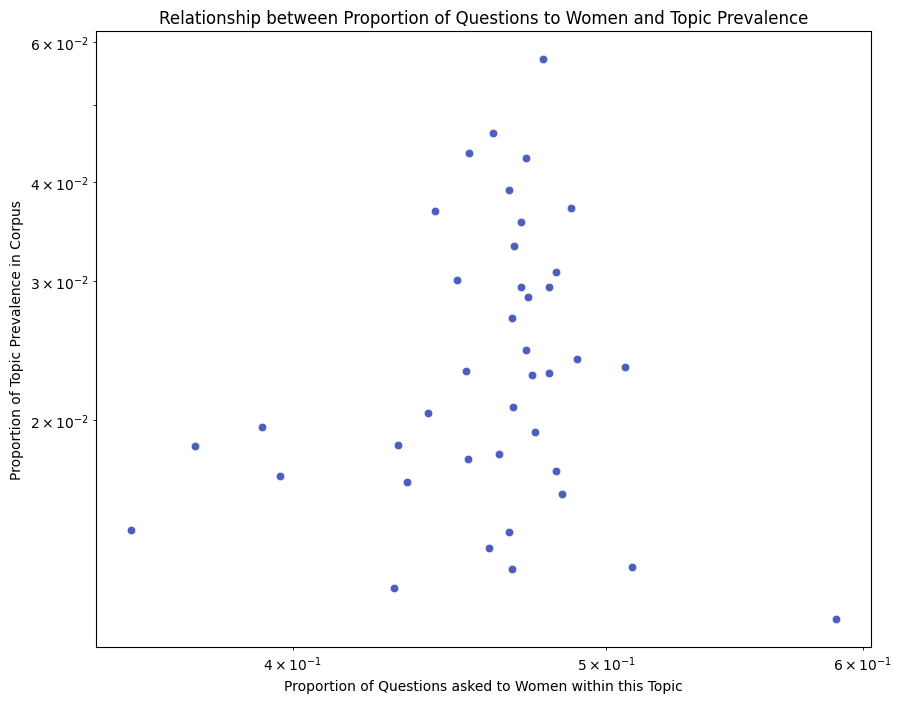

In [244]:

# Set up the figure and axis
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Scatter plot with log scales
sns.scatterplot(x='proportion', y='proportion_of_topic', data=joined_with_gender_topics_female, ax=ax, alpha=0.7, marker='o')

# Set log scales for better visualization
ax.set_xscale('log')
ax.set_yscale('log')

# Set labels and title
plt.xlabel('Proportion of Questions asked to Women within this Topic')
plt.ylabel('Proportion of Topic Prevalence in Corpus')
plt.title('Relationship between Proportion of Questions to Women and Topic Prevalence')

# Show the plot
plt.show()


The reason that this chart was plotted is to show that there may have been some incorrect/misinterpreted analysis in the first paper, which was featured in the NYT for describing how women are asked the stranger questions. We see here that there is a very weak correlation between the prevalence of a topic in the LDA model trained on the whole corpus and the proportion of questions asked to women in this topic. However! It is important to note that we do see a difference in topics when trained on just the women group and just the men group. This suggests that perhaps the relationship here is smaller because there are more questions asked to women.

#### Predictive Modelling

Finally, because we saw that there is a statistically significant relationship between gender and the topic label for most likely topic, let's also train a logistic regression model to see how accuractely the extracted topics can be used to predict gender.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



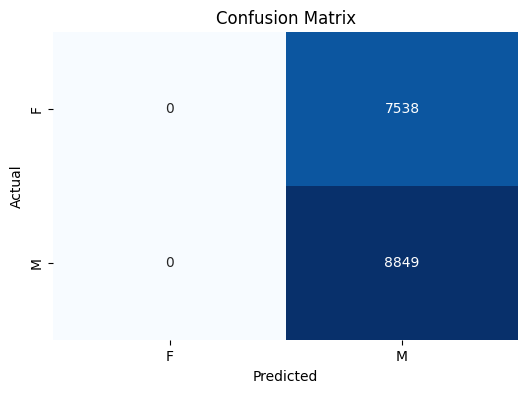

In [249]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming questions_df_cleaned is your DataFrame with 'most_likely_topic_40_topics' and 'gender' columns

# Encode 'gender' as numeric
label_encoder = LabelEncoder()
questions_df_cleaned['gender_encoded'] = label_encoder.fit_transform(questions_df_cleaned['gender'])

# Convert 'most_likely_topic_40_topics' to a categorical variable with 40 categories
questions_df_cleaned['most_likely_topic_40_topics'] = questions_df_cleaned['most_likely_topic_40_topics'].astype('category')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    questions_df_cleaned[['most_likely_topic_40_topics']],
    questions_df_cleaned['gender_encoded'],
    test_size=0.2,
    random_state=42
)

# Determine class weights to account for imbalance
class_weights = dict(zip([0, 1], len(y_train) / (2 * pd.value_counts(y_train))))

# Train a logistic regression model with class weights
model = LogisticRegression(class_weight=class_weights, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [250]:
from sklearn.metrics import roc_auc_score, f1_score

# Calculate AUC
auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Calculate F1 score
f1_score_value = f1_score(y_test, y_pred)

# Print the AUC and F1 score
print(f'AUC: {auc_score:.4f}')
print(f'F1 Score: {f1_score_value:.4f}')


AUC: 0.4947
F1 Score: 0.7013


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



This demonstrates that the topics cannot be used as effective features with high accuracy to predict gender, which suggests that there may not be a clear delineation on the topics that demonstrates whether a question is being asked to a male or female player.